In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2 as cv
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model
import seaborn as sn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
import re
import math
from keras.preprocessing import image


In [2]:
#refrenced by OpenCV documentation 
#https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
new_dir = "Celebrity_Extracted_Face_Dataset"

if not os.path.isdir(new_dir):
    os.mkdir(new_dir)

def detectFace(original_directory):
    sub_dirs = os.listdir(original_directory)
    face_cascade = cv.CascadeClassifier("./haarcascade_frontalface_default.xml")
    for sub_dir in sub_dirs:
        new_sub_dir = os.path.join(new_dir, sub_dir)
        if not os.path.isdir(new_sub_dir):
            os.mkdir(new_sub_dir)
        images = os.listdir(os.path.join(original_directory, sub_dir))
        for image in images:
            frame = cv.imread(os.path.join(os.path.join(original_directory, sub_dir), image))
            frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            frame_gray = cv.equalizeHist(frame_gray)
            faces = face_cascade.detectMultiScale(frame_gray)
            for x, y, w, h in faces:
                cv.imwrite(os.path.join(new_sub_dir, image), frame[y:(y+h), x:(x+w), :], [cv.IMWRITE_JPEG_QUALITY, 100])
    

In [3]:
def rename_file(directory, count = 1):
    try:
        sub_dirs = os.listdir(directory)
        print(sub_dirs)
        for sub_dir in sub_dirs:
            cur_sub_dir = os.path.join(directory, sub_dir)
            prefix = sub_dir
            files = os.listdir(cur_sub_dir)
            image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')
            for filename in files:
                new_name = f"{prefix}_Face_{count}.jpg"
                os.rename(os.path.join(cur_sub_dir, filename), os.path.join(cur_sub_dir, new_name))
                count += 1
    except Exception as e: 
        print("error occrured ", e)


In [4]:

import shutil
def copy_to_main_training_set(train_dir, delta_dir):
    try:
        training_sub_dirs = os.listdir(train_dir)
        delta_sub_dirs    = os.listdir(delta_dir)
        
        for train_sub_dir in training_sub_dirs:
            dest_path = os.path.join(train_dir, train_sub_dir)
            
            for delta_sub_dir in delta_sub_dirs:
                if delta_sub_dir == train_sub_dir:
                    cur_path = os.path.join(delta_dir, delta_sub_dir)
                    files = os.listdir(cur_path)
                    for file in files:
                        try:
                            shutil.copy(os.path.join(cur_path, file), dest_path)
                            print("Copied ", len(files), " images for ", "class labeled ", delta_sub_dir)
                        except Exception as e:
                            print("Cannot copy file, ", e ) 
    except Exception as e:
        print("Error occured, ", e)

In [32]:
def image_to_nparray_macro(sample_image, target_size = (450, 450)):
    test_image=image.load_img(sample_image,target_size= target_size)
    test_image.point(lambda p: p + 1.5)
    test_image=image.img_to_array(test_image) / 255
    test_image=np.expand_dims(test_image,axis=0)
    return test_image

In [34]:

#using keras ImageDataGenerator to populate new image data for testing and training
#refernece based on:
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
#https://thinkingneuron.com/face-recognition-using-deep-learning-cnn-in-python/
train_image_path = "./Celebrity_Faces_Dataset"

train_preproc_imgdata_gen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range= 40,
            width_shift_range= 0.2,
            height_shift_range= 0.2,
            zoom_range= 0.2,
            shear_range= 0.2,
            horizontal_flip=True,
            fill_mode= "nearest",
            brightness_range = (0.5, 1.5),
            validation_split = 0.2
            )

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

training_set = train_preproc_imgdata_gen.flow_from_directory(
            train_image_path,
            target_size= (450, 450),
            batch_size = 32,
            class_mode = "categorical"
            )

validation_set = test_datagen.flow_from_directory(
                train_image_path,
                target_size= (450, 450),
                batch_size = 16,
                subset = "training",
                class_mode = "categorical"
)
testing_set = test_datagen.flow_from_directory(
            train_image_path,
            target_size= (450, 450),
            batch_size = 16,
            subset = "validation",
            class_mode = "categorical"
            )

training_set.class_indices

Found 3218 images belonging to 17 classes.
Found 2582 images belonging to 17 classes.
Found 636 images belonging to 17 classes.


{'Angelina_Jolie': 0,
 'Brad_Pitt': 1,
 'Denzel_Washington': 2,
 'Hugh_Jackman': 3,
 'Jennifer_Lawrence': 4,
 'Johnny_Depp': 5,
 'Kate_Winslet': 6,
 'Leonardo_DiCaprio': 7,
 'Megan_Fox': 8,
 'Natalie_Portman': 9,
 'Nicole_Kidman': 10,
 'Robert_Downey_Jr': 11,
 'Sandra_Bullock': 12,
 'Scarlett_Johansson': 13,
 'Tom_Cruise': 14,
 'Tom_Hanks': 15,
 'Will Smith': 16}

In [36]:
# Reference : https://www.tensorflow.org/tutorials/keras/classification
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

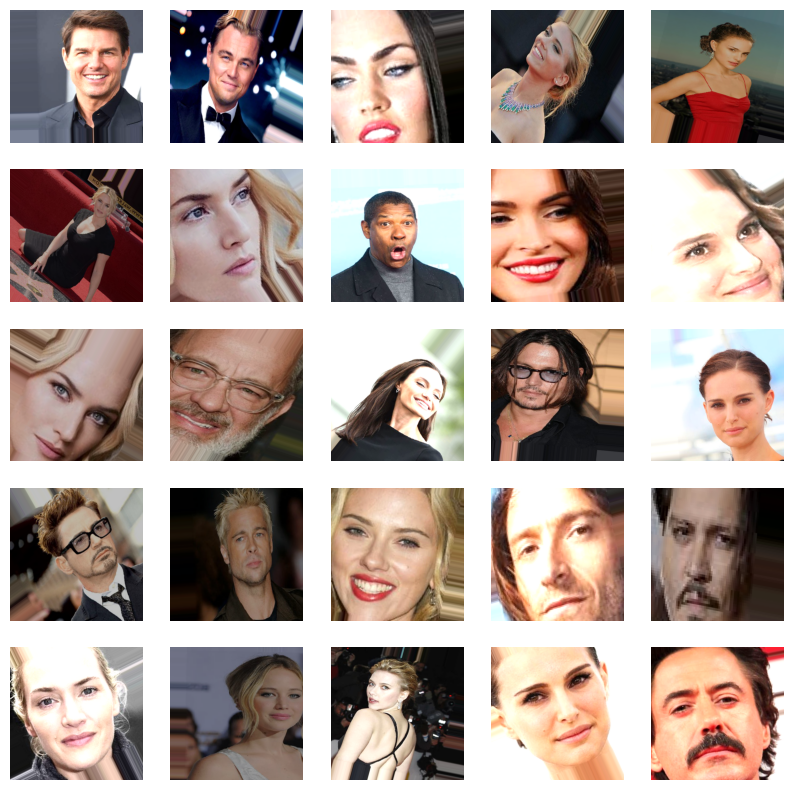

In [8]:

image_batch, label_batch = next(training_set)
show_batch(image_batch, label_batch)

In [38]:
#create a mapping relate to integer index to the its name instead
result_map = {}
for celeb_index, celeb_name in zip(training_set.class_indices.values(), training_set.class_indices.keys()):
        result_map[celeb_index] = celeb_name
#save this map to be used in the final layers of our CNN
print(result_map)
output_neuron_layer = len(result_map)

{0: 'Angelina_Jolie', 1: 'Brad_Pitt', 2: 'Denzel_Washington', 3: 'Hugh_Jackman', 4: 'Jennifer_Lawrence', 5: 'Johnny_Depp', 6: 'Kate_Winslet', 7: 'Leonardo_DiCaprio', 8: 'Megan_Fox', 9: 'Natalie_Portman', 10: 'Nicole_Kidman', 11: 'Robert_Downey_Jr', 12: 'Sandra_Bullock', 13: 'Scarlett_Johansson', 14: 'Tom_Cruise', 15: 'Tom_Hanks', 16: 'Will Smith'}


In [40]:
print(output_neuron_layer)

17


In [42]:
#initializing CNN layers
import keras
from keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization





In [44]:
model = Sequential()
model.add(keras.Input(shape=(450, 450, 3)))
model.add(Conv2D(32, (3, 3), padding= "same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(64, (3, 3), padding= "same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(output_neuron_layer))
model.add(Activation("softmax"))



In [46]:
model.load_weights("celeb_o7_v2.weights.h5")
model.compile(optimizer = keras.optimizers.Adam(learning_rate= 0.000001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy", keras.metrics.F1Score, 
                        keras.metrics.Precision, keras.metrics.Recall],
             )

In [48]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 450, 450, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 450, 450, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 150, 150, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 23, 23, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 23, 23, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,113,361 (8.06 MB)

 Trainable params: 2,112,337 (8.06 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
log_history = CSVLogger("my_model_history_ver_2.csv", append = True)
save_model = ModelCheckpoint("celeb_o7_v2_model.keras", monitor= "val_accuracy", save_best_only= True)
save_weight = ModelCheckpoint("celeb_o7_v2.weights.h5", monitor= "val_accuracy", save_weights_only= True, save_best_only= True)
my_model_history = model.fit(
        training_set,
        steps_per_epoch = 3218 // 32,
        epochs = 200,
        validation_data = validation_set,
        validation_steps = 2582 // 16,
        callbacks = [log_history, save_model, save_weight]
      )


C:\Users\nhle1\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 450, 450, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
(1, 450, 450, 32)
(1, 150, 150, 64)
(1, 75, 75, 128)
(1, 23, 23, 256)
(1, 5, 5, 512)


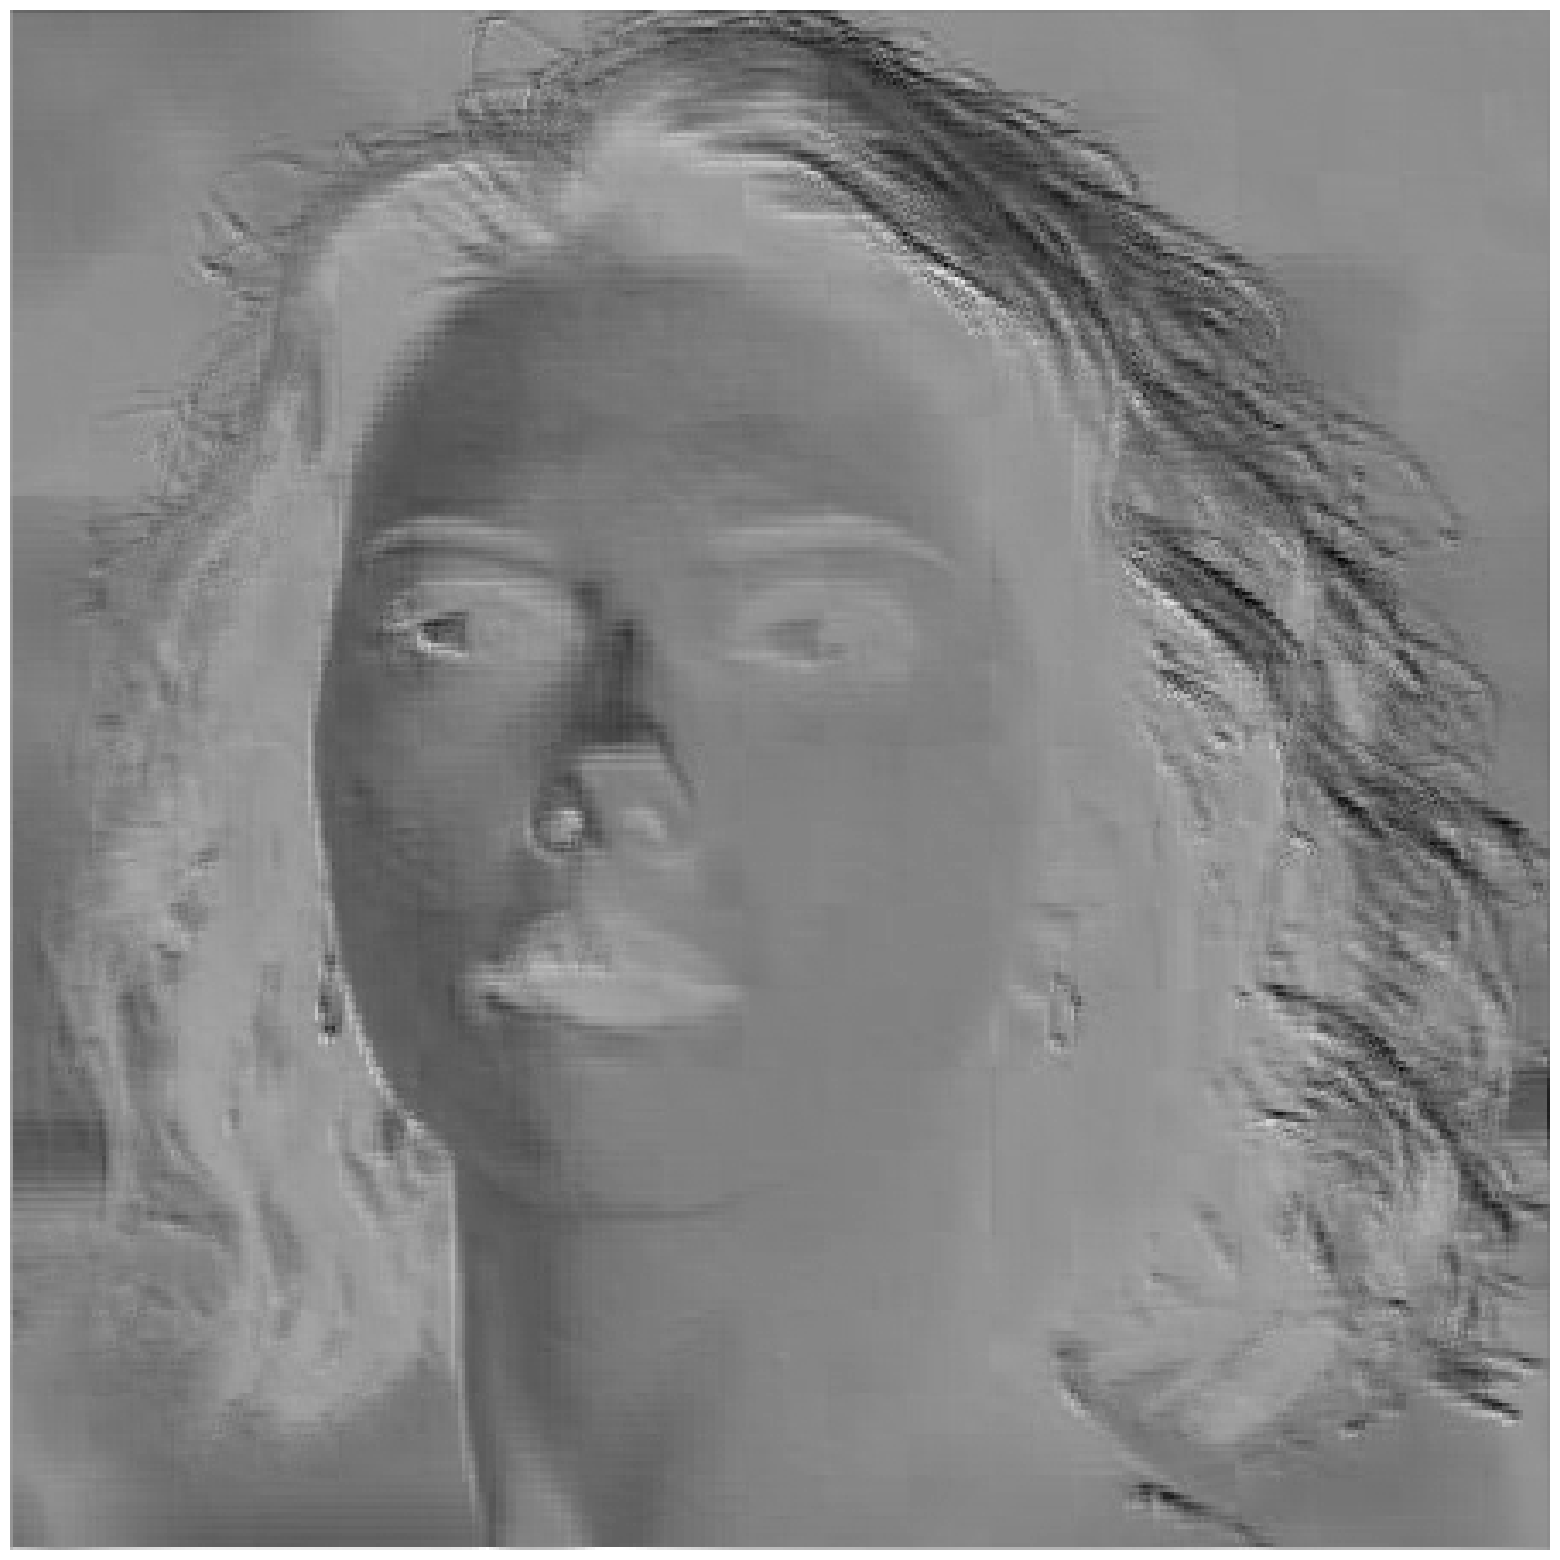

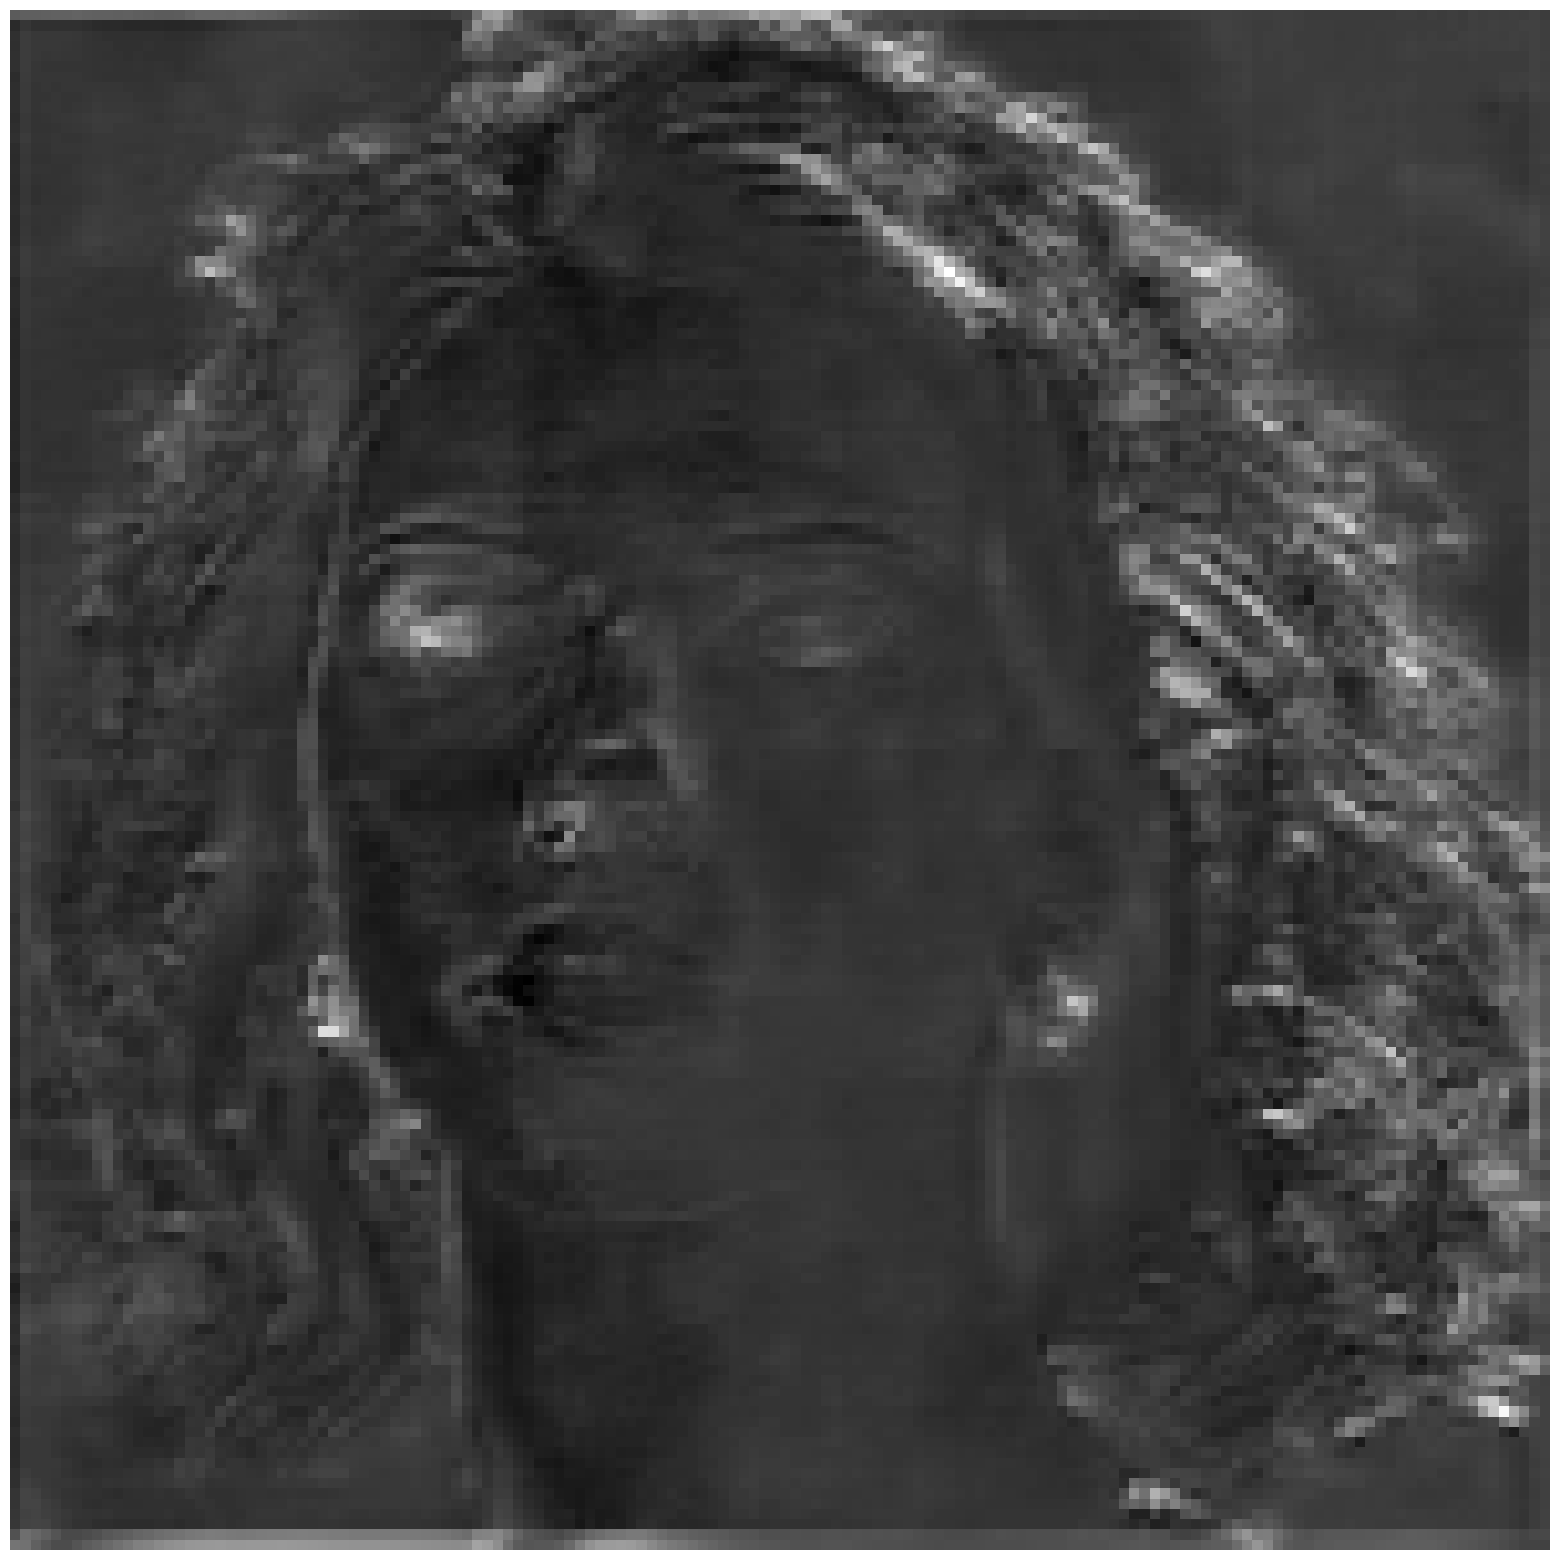

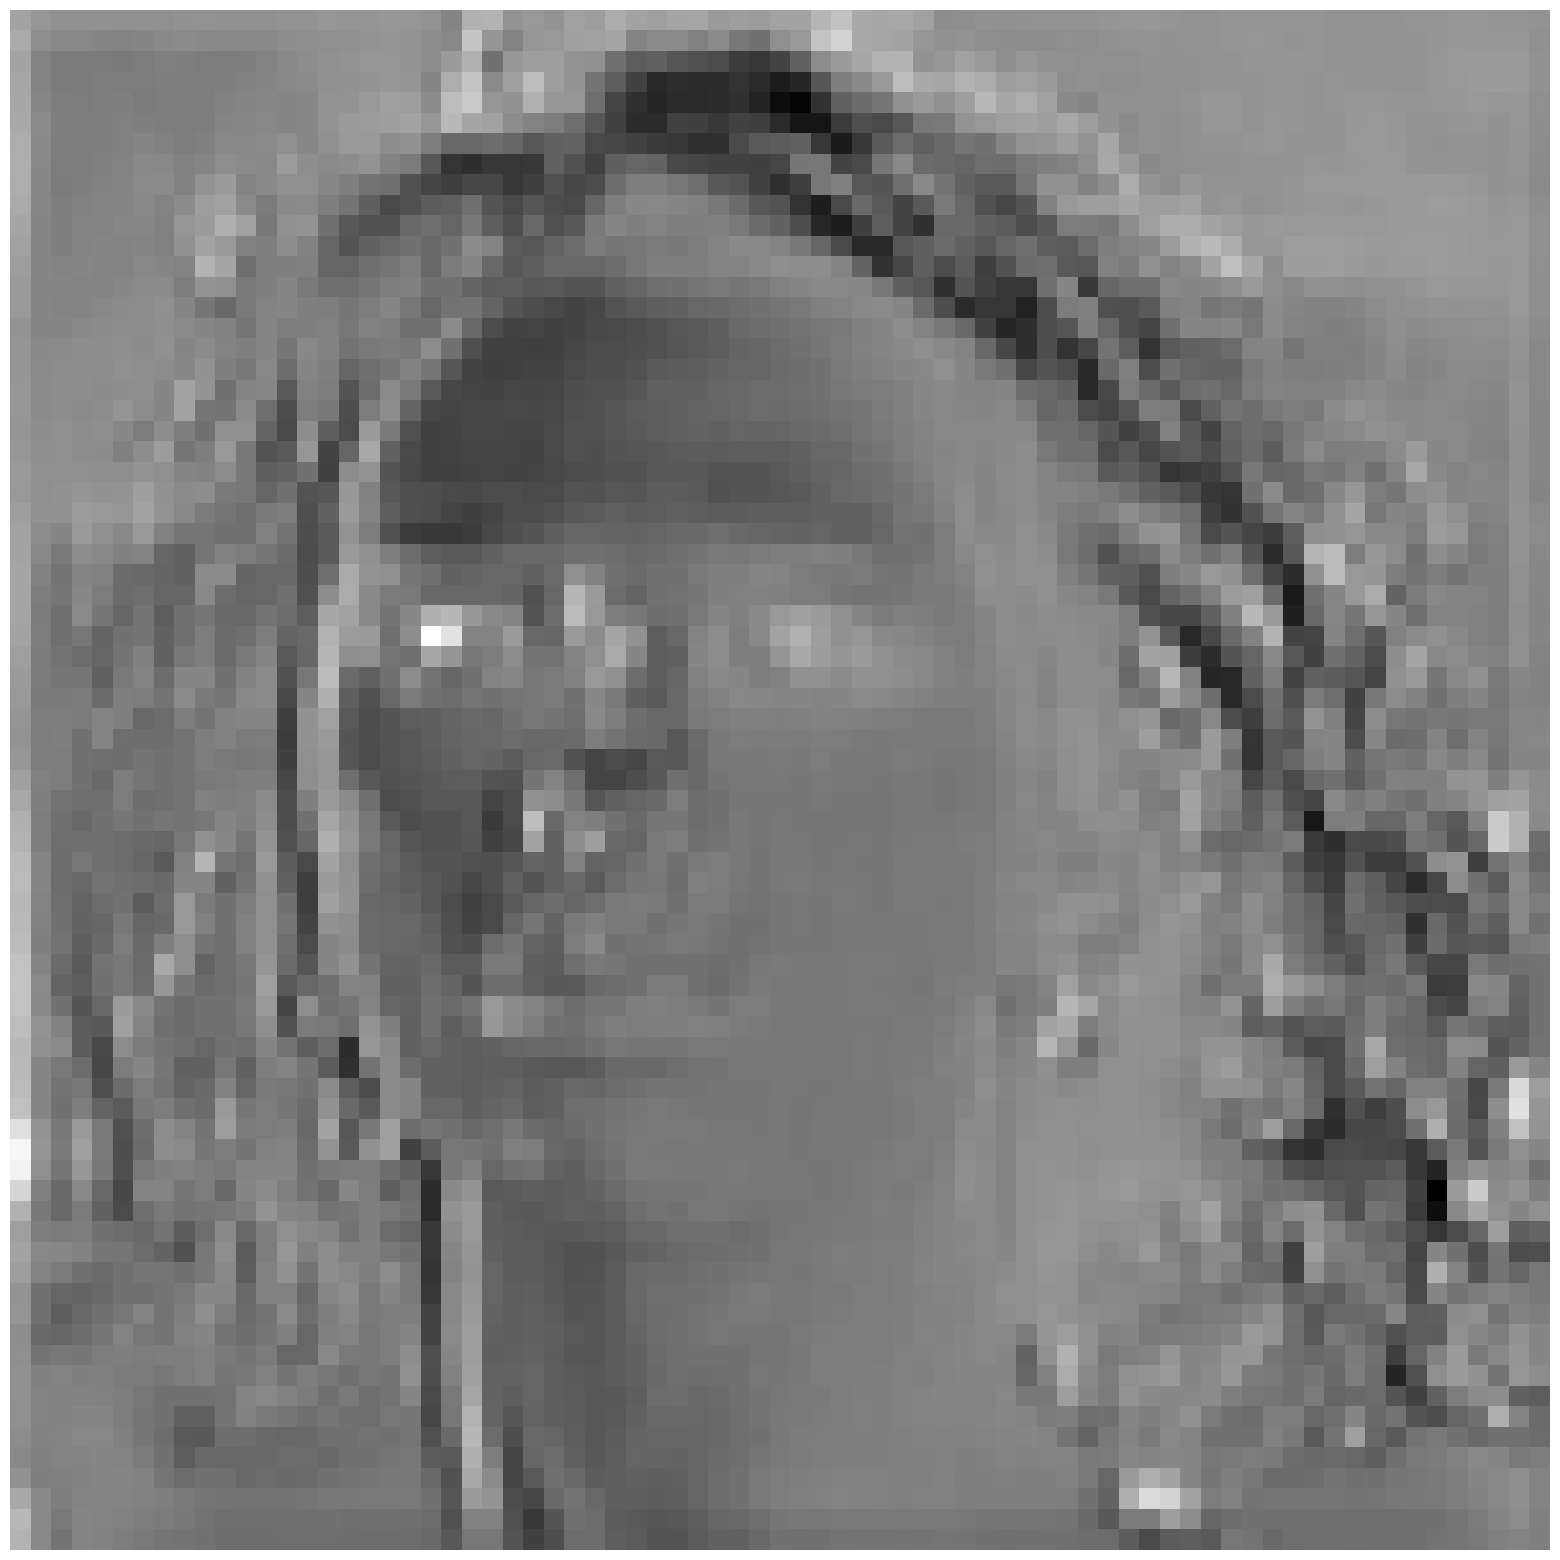

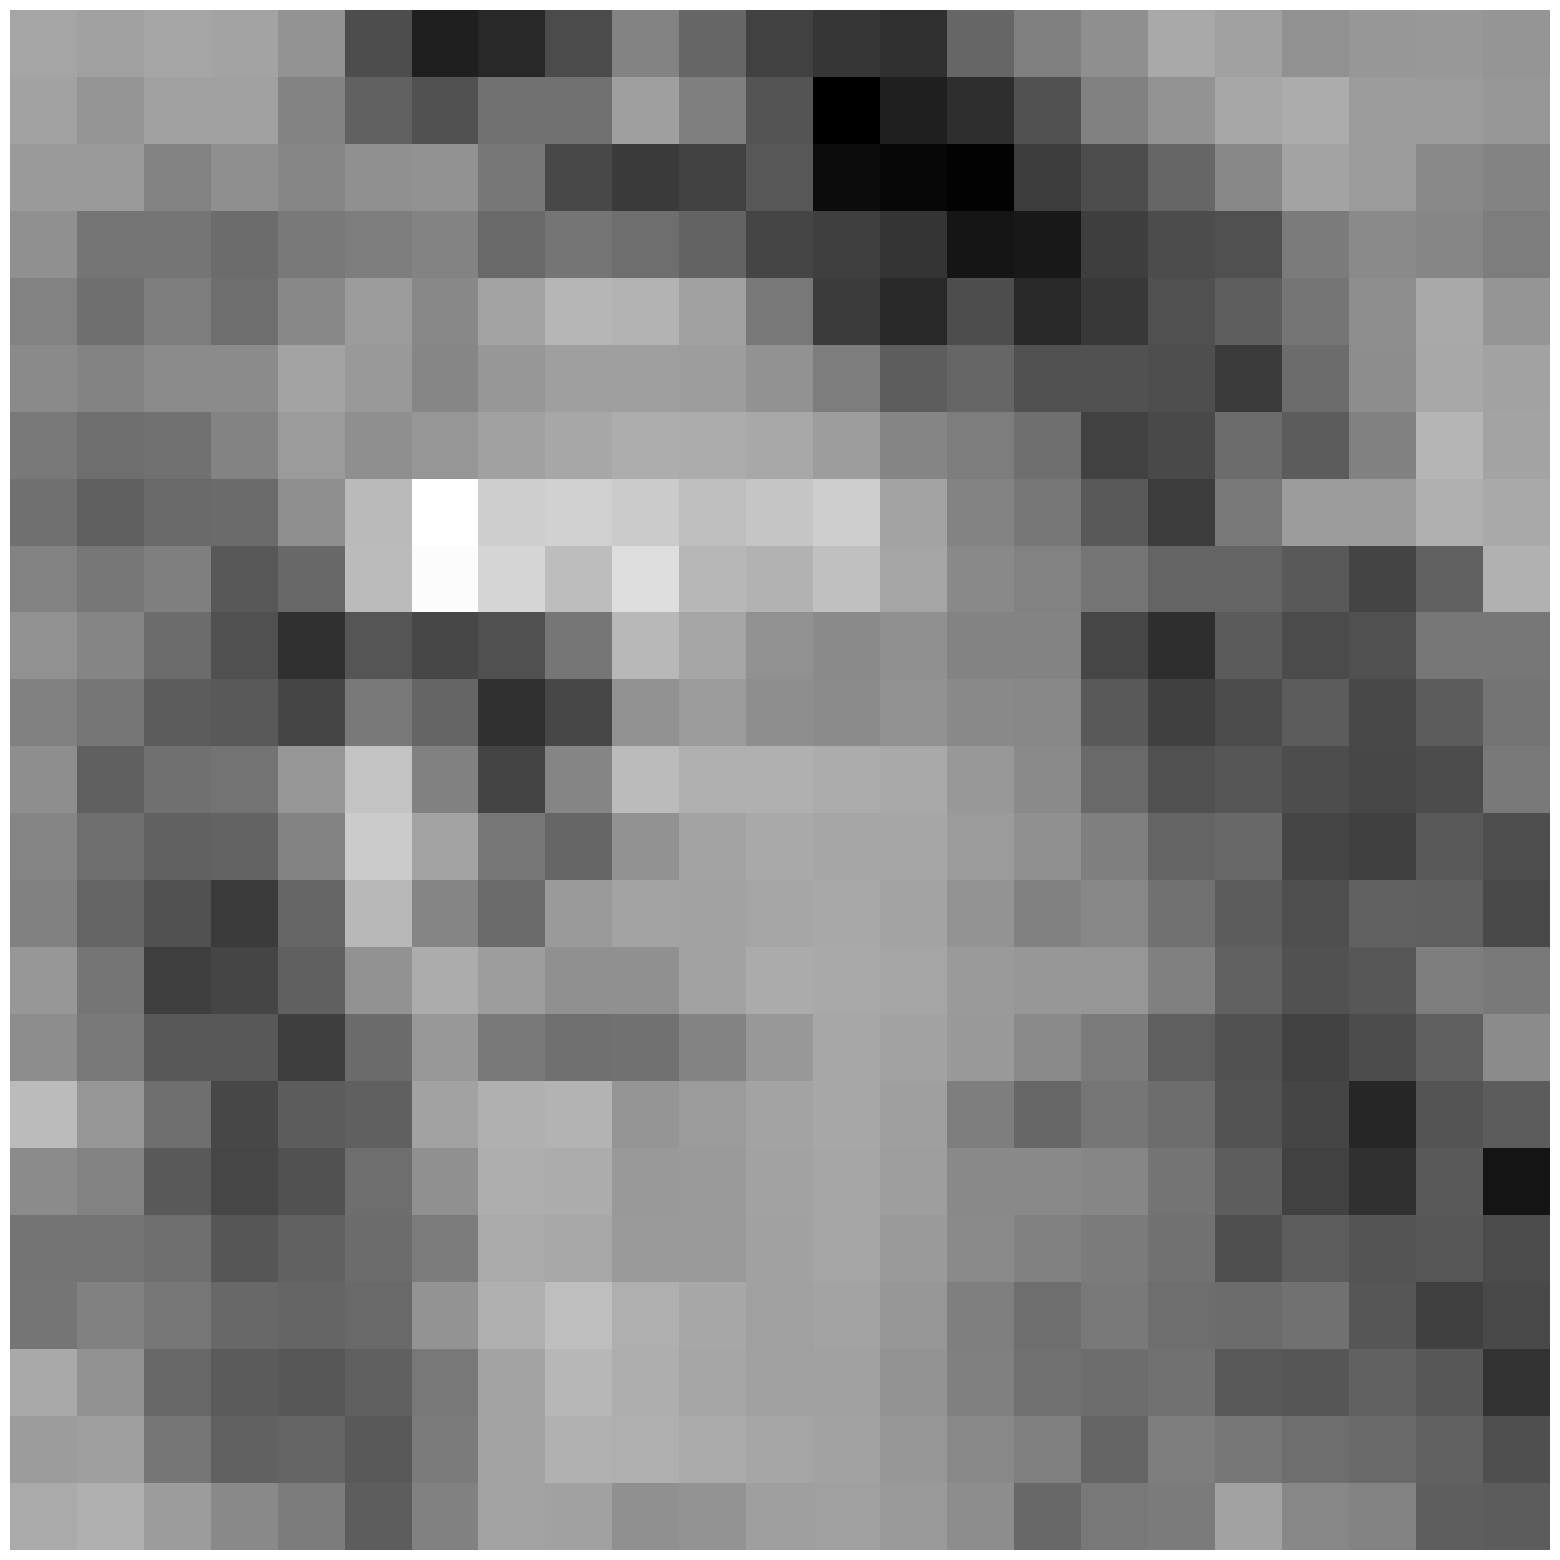

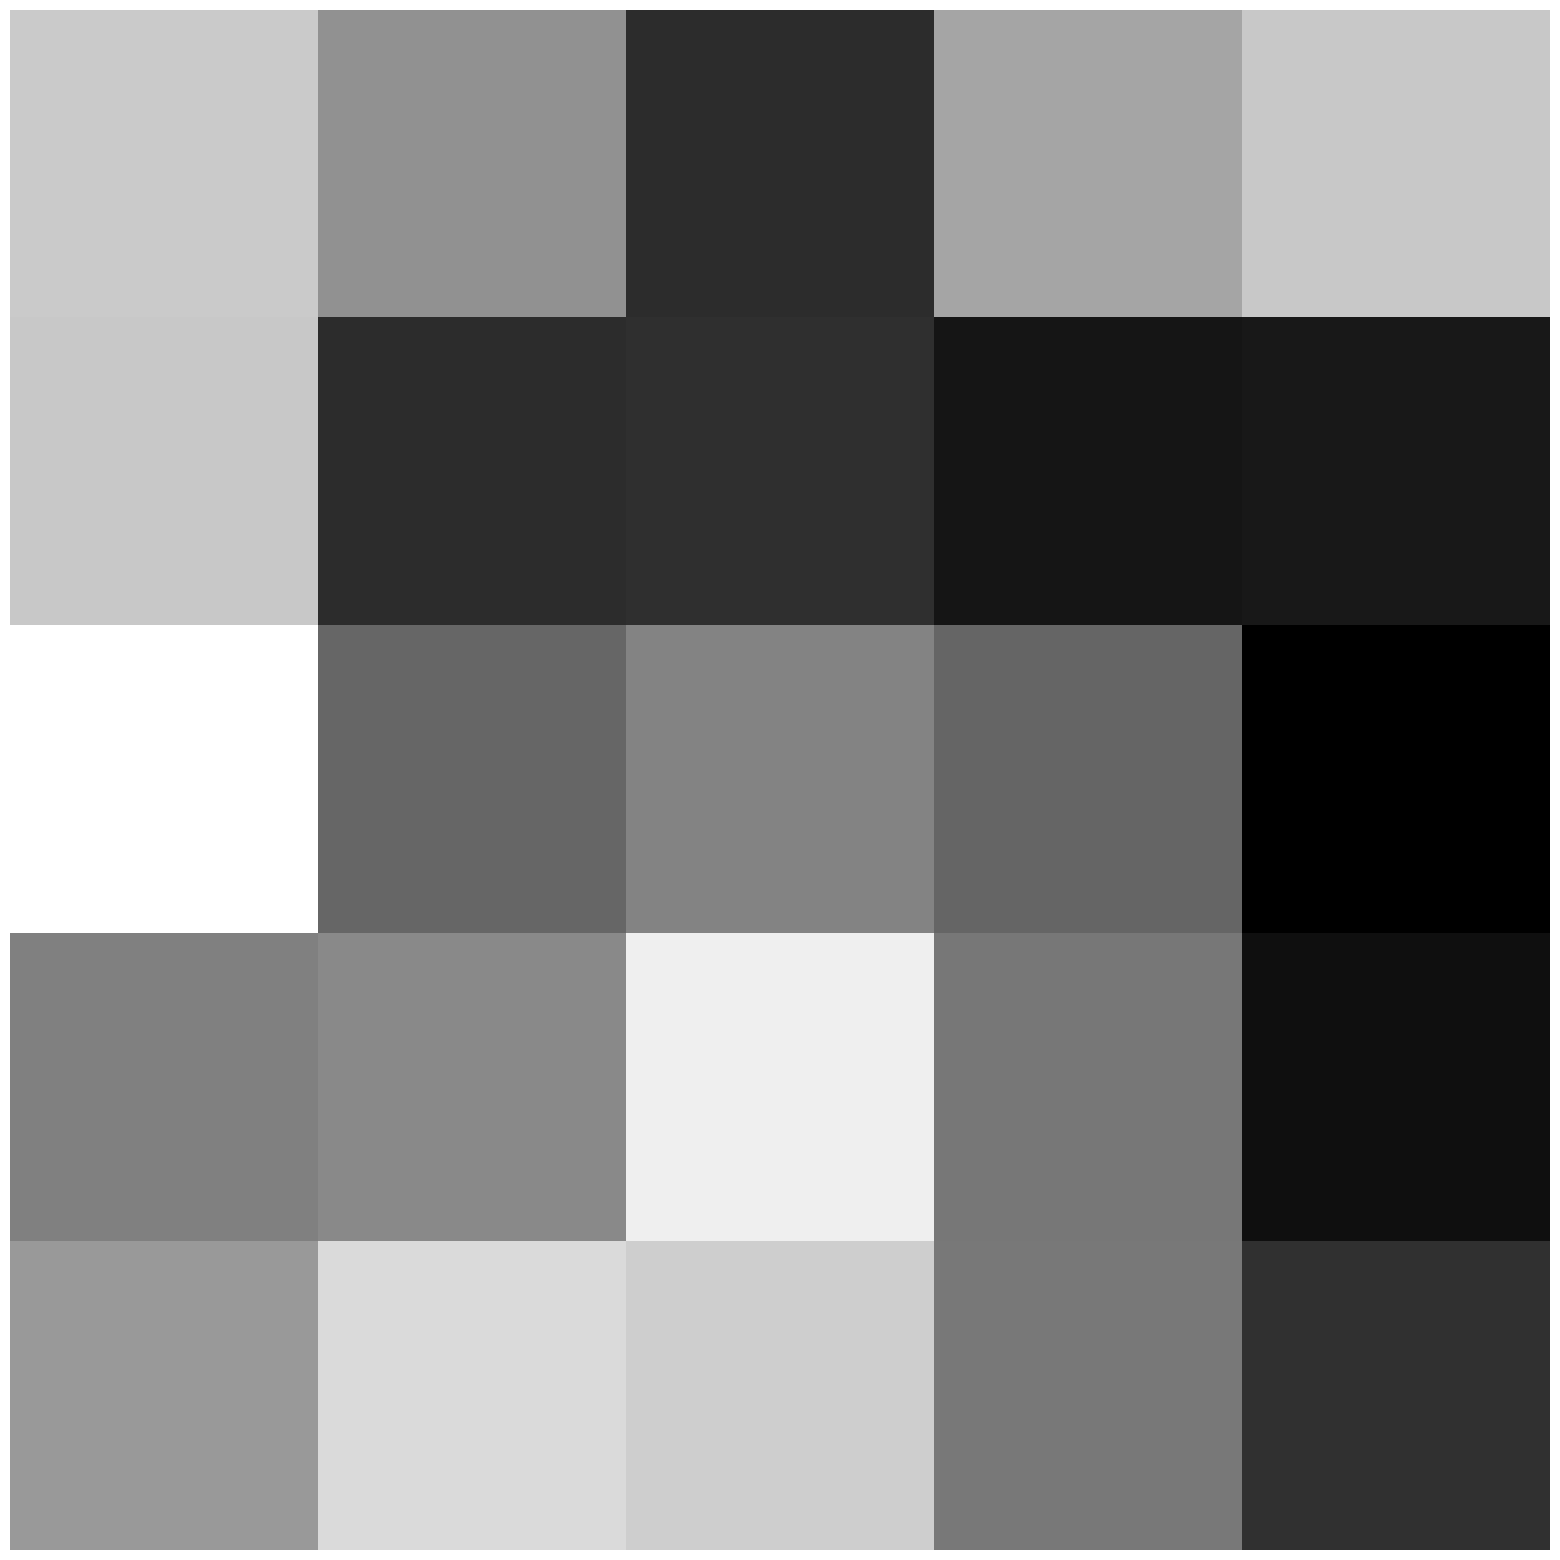

In [15]:
#refrenced https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
def visualize_cnn_layers(model):
    activations_model = Model(inputs = model.inputs, outputs = [layer.output for layer in model.layers if isinstance (layer, (Conv2D))])
    feature_maps = activations_model.predict(image_to_nparray_macro("./Celebrity_Faces_Test/Scarlett_Johansson_Test_2.jpg"), verbose = 1)
    
    for index, layer in enumerate(feature_maps):
        print(feature_maps[index].shape)
        plt.figure(figsize = (20, 20))
        num_filters = feature_maps[index].shape[-1] 
        plt.imshow(feature_maps[index][0,:,:,num_filters - 1], cmap = "gray")
        plt.axis("off")
    plt.show()
    plt.close()
visualize_cnn_layers(model)

In [7]:
def plot_history(history_csv):
    model_history = pd.read_csv(history_csv)
    plt.plot(model_history.loss, label='train_loss')
    plt.plot(model_history.val_loss, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')

In [9]:
def predict_single_image(model, test_image_path, target_size):
    test_image=image.load_img(test_image_path,target_size= target_size)
    test_image.point(lambda p: p + 1.5)
    test_image=image.img_to_array(test_image) / 255
    test_image=np.expand_dims(test_image,axis=0)
    result= model.predict(test_image,verbose=0)
    #print('Prediction is: ', result_map[np.argmax(result)])
    return result_map[np.argmax(result)]

In [11]:
def predict_unseen_testing_set(model, testing_set):
    rows, cols = 4, 4 #batch size of 16
    truth = 0
    n = 0
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    fig.suptitle("Predicted vs. True Label on Unseen Data", fontsize = 14)
    fig.subplots_adjust(top=0.92, hspace=0.5)
    image_batch, label_batch = next(testing_set)
    result = model.predict(image_batch, verbose = 0)
    for i in range(16):
        prediction = result_map[np.argmax(result[i])]
        true_label = result_map[np.argmax(label_batch[i])]
        row = i // cols
        col = i % cols
        axes[row, col].imshow(image_batch[i])
        axes[row, col].set_title(f"P: {prediction}, T: {true_label}", fontsize=5)
        axes[row, col].axis("off") 
        if prediction == true_label:
            truth += 1 
        n += 1
    plt.show()
    plt.close()
    return truth /n

In [13]:
def Random_Faces_Test(model):
    test_path = "./Celebrity_Faces_Test/"
    images_file = [i for i in os.listdir(test_path) if i.endswith(".jpg") or i.endswith(".JPG")]
    n = len(images_file)
    cols = math.ceil(math.sqrt(n))    
    rows = math.ceil(n / cols)     
    truth = 0
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    fig.subplots_adjust(top=0.92, hspace=0.5)
    plt.axis("off")
         
    plt.suptitle("Random Faces Test", fontsize = 16)
    for i in range(n):
        image_path = os.path.join(test_path, images_file[i])
        prediction = predict_single_image(model, image_path, (450, 450))
        row = i // cols
        col = i % cols
        img = plt.imread(image_path)
        axes[row, col].imshow(img)
        axes[row, col].set_title(prediction, fontsize=5)
        axes[row, col].axis("off")
        truth_label = re.sub(r"(?:Test_\d+|\d+|_|.JPEG|.jpeg|.jpg)", " ", images_file[i])
        if(prediction.replace("_", " ") in truth_label):
            truth += 1
    for i in range(n, rows * cols):
        axes[i //cols, i % cols].axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

    return (truth / n )

In [15]:
def show_cm(model, testing_set):
    predictions = model.predict(testing_set)
    predicted_celeb = np.argmax(predictions, axis = 1)
    print(predictions.shape, testing_set.n, predicted_celeb.shape)
    cm = confusion_matrix(testing_set.labels, predicted_celeb)
    ConfusionMatrixDisplay.from_predictions(testing_set.labels, predicted_celeb)
    plt.show()

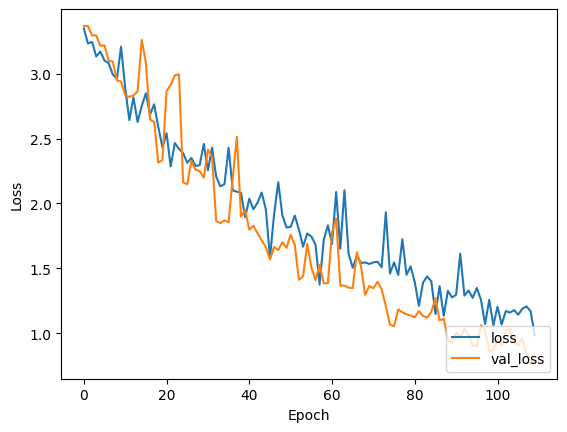

In [55]:
plot_history("my_model_history.csv")

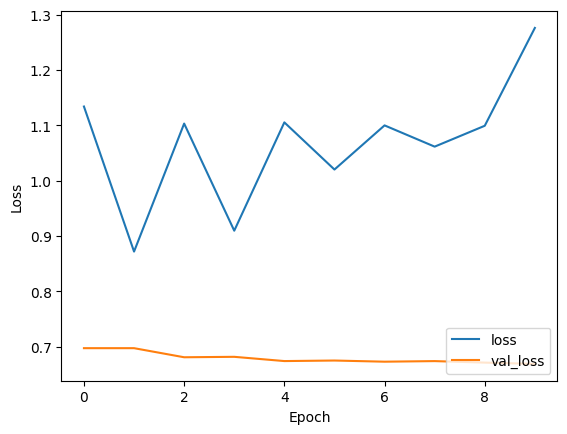

In [38]:
plot_history("my_model_history_ver_2.csv")

In [17]:
#the model is performing well but performing really bad on unseen images, we can either 
#get more image data or use transfer learning on a pretrain model
from keras.applications.mobilenet import MobileNet

In [19]:
base_model = MobileNet(weights = "imagenet", 
                   include_top=False,
                  input_shape=(450, 450, 3))



C:\Users\nhle1\AppData\Local\Temp\ipykernel_17576\3321110711.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights = "imagenet",


In [42]:
base_model.trainable = False
base_model.summary()

base_model_conv_layers = [layer for layer in base_model.layers if isinstance(layer, Conv2D)]
base_model_layer_outputs = [layer.output for layer in base_model_conv_layers]

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 450, 450, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 225, 225, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 225, 225, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 225, 225, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 225, 225, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 225, 225, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 225, 225, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 225, 225, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 225, 225, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 225, 225, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 226, 226, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 112, 112, 64)   │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 112, 112, 128)  │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 112, 112, 128)  │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 112, 112, 128)  │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [38]:
#now transefer this to a new model with our own model??

transfer_model = Sequential()

transfer_model.add(base_model)
transfer_model.add(GlobalAveragePooling2D())
transfer_model.add(Dense(512, kernel_regularizer=regularizers.l2(0.0001)))
transfer_model.add(Activation("relu"))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(output_neuron_layer))
transfer_model.add(Activation("softmax"))


In [39]:
transfer_model.summary(show_trainable=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ mobilenet_1.00_224          │ (None, 14, 14, 1024)  │  3,228,864 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 1024)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 512)           │    524,800 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_9 (Activation)   │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 17)            │      8,721 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_10 (Activation)  │ (None, 17)            │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 3,762,385 (14.35 MB)

 Trainable params: 533,521 (2.04 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [40]:
transfer_model.load_weights("transfer_mobilenet_model.weights.h5")
transfer_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate= 0.0001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy", keras.metrics.F1Score, keras.metrics.Precision, keras.metrics.Recall]
    
)

In [ ]:

log_history = CSVLogger("my_mobilenet_history_ver_2.csv", append = True)
save_model = ModelCheckpoint("my_mobilenet_v2_model.keras", monitor= "val_accuracy", save_best_only= True)
save_weight = ModelCheckpoint("my_mobilenet_v2.weights.h5", monitor= "val_accuracy", save_weights_only= True, save_best_only= True)
transfer_history = transfer_model.fit(
        training_set,
        steps_per_epoch = 3200 // 32,
        epochs = 10,
        validation_data = validation_set,
        validation_steps = 600 // 16,
        callbacks = [early_stop, log_history, save_model, save_weight]
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
(1, 225, 225, 32)
(1, 225, 225, 64)
(1, 112, 112, 128)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 14, 14, 1024)
(1, 14, 14, 1024)


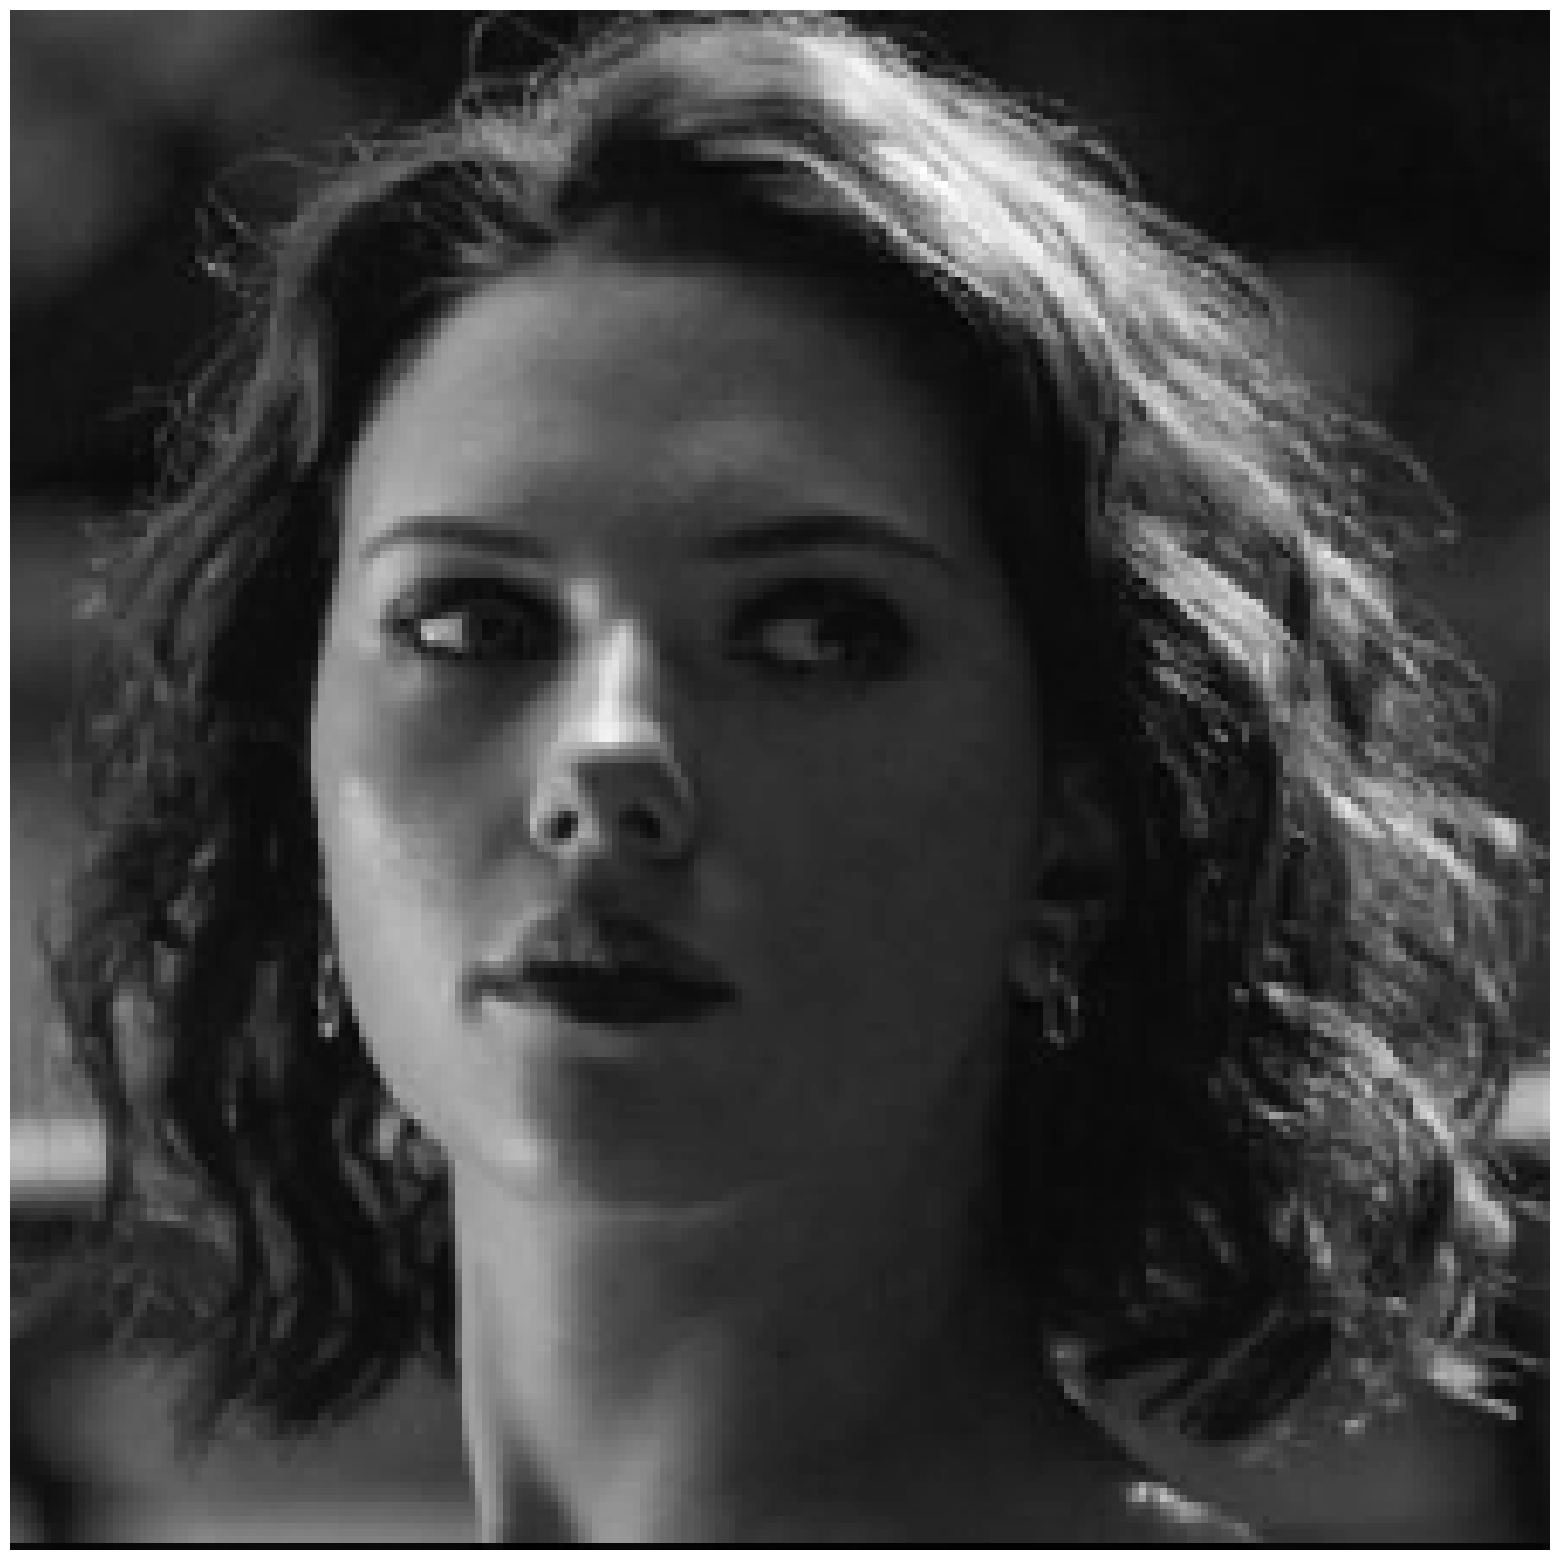

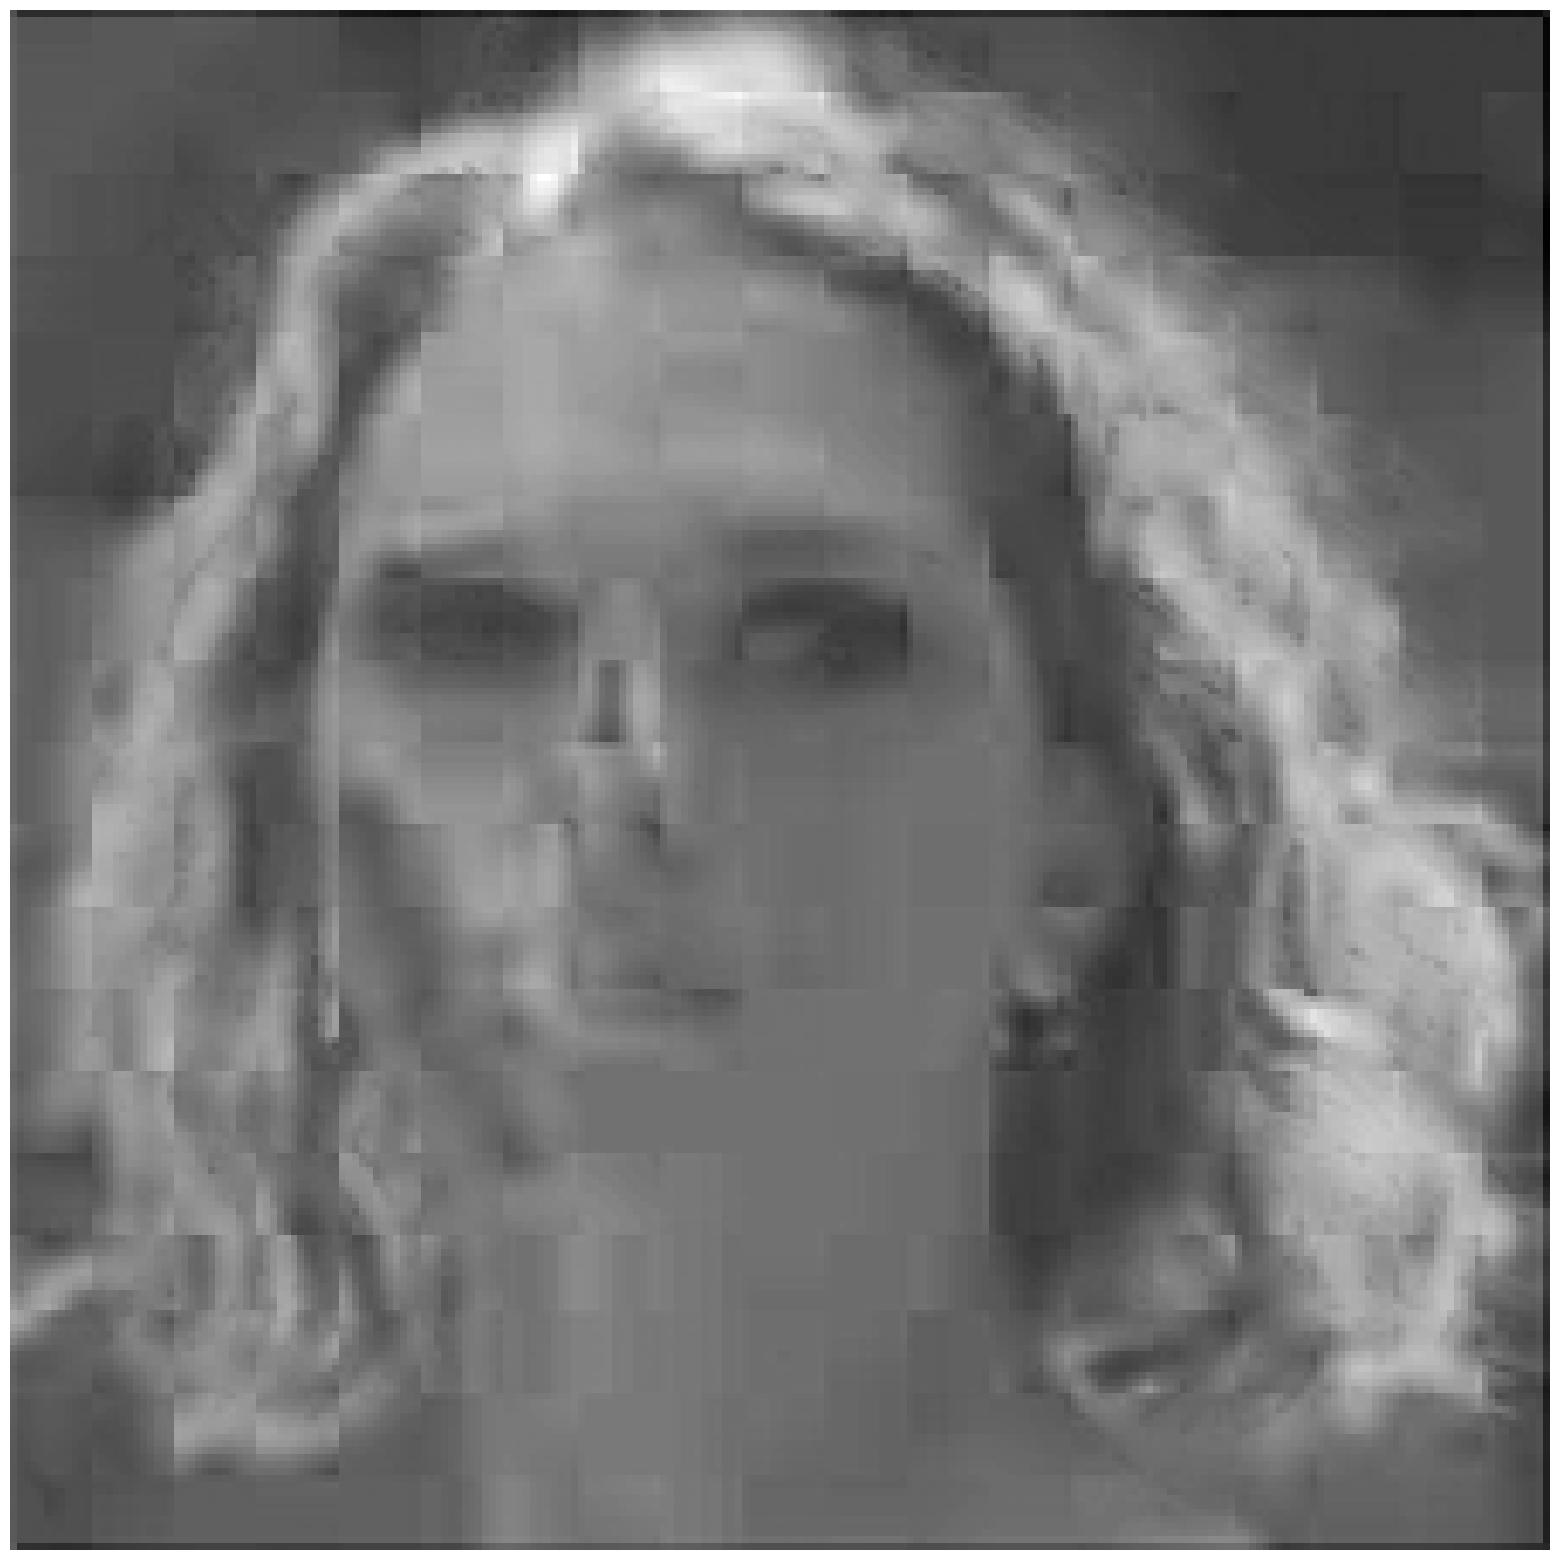

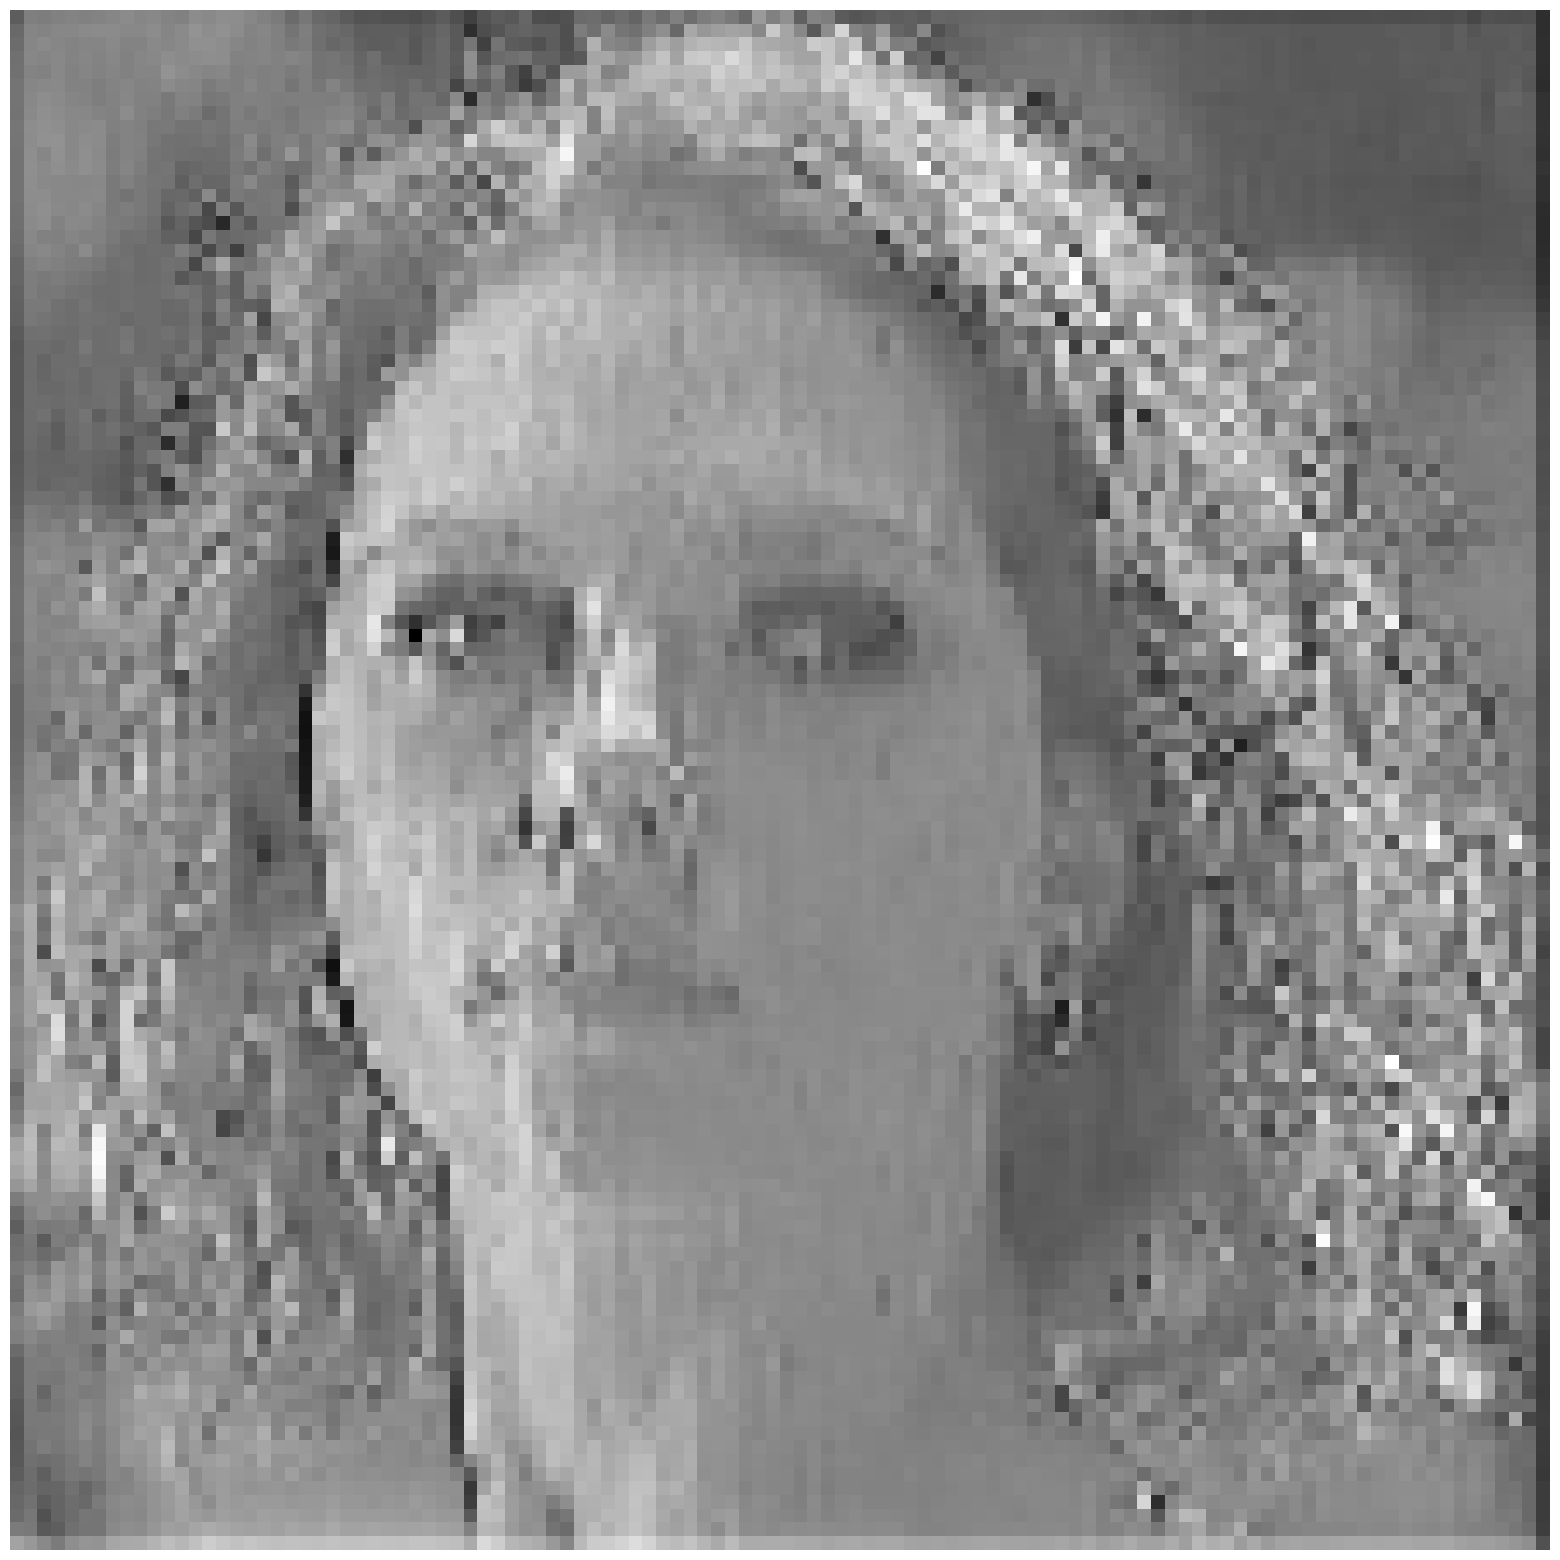

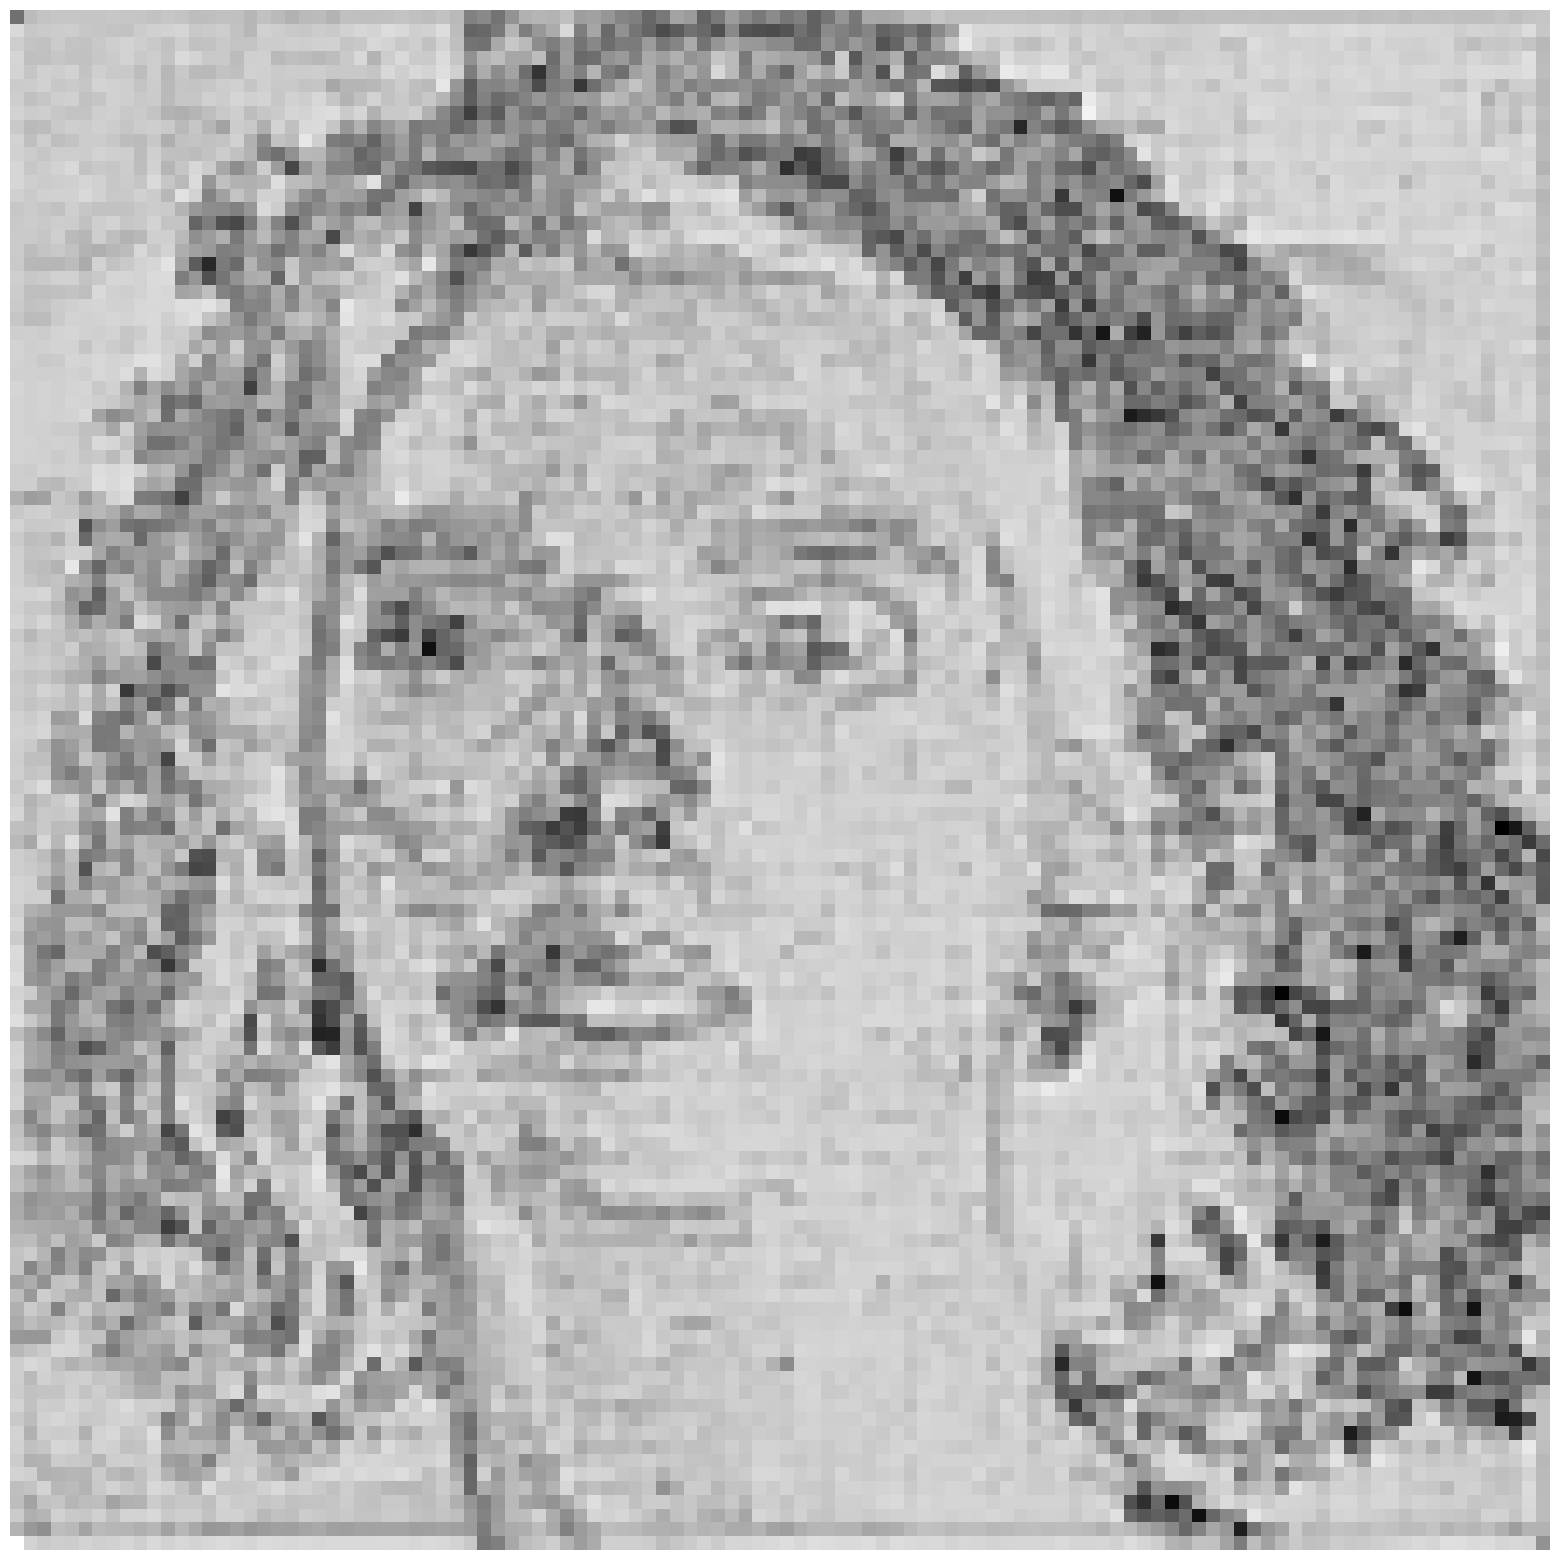

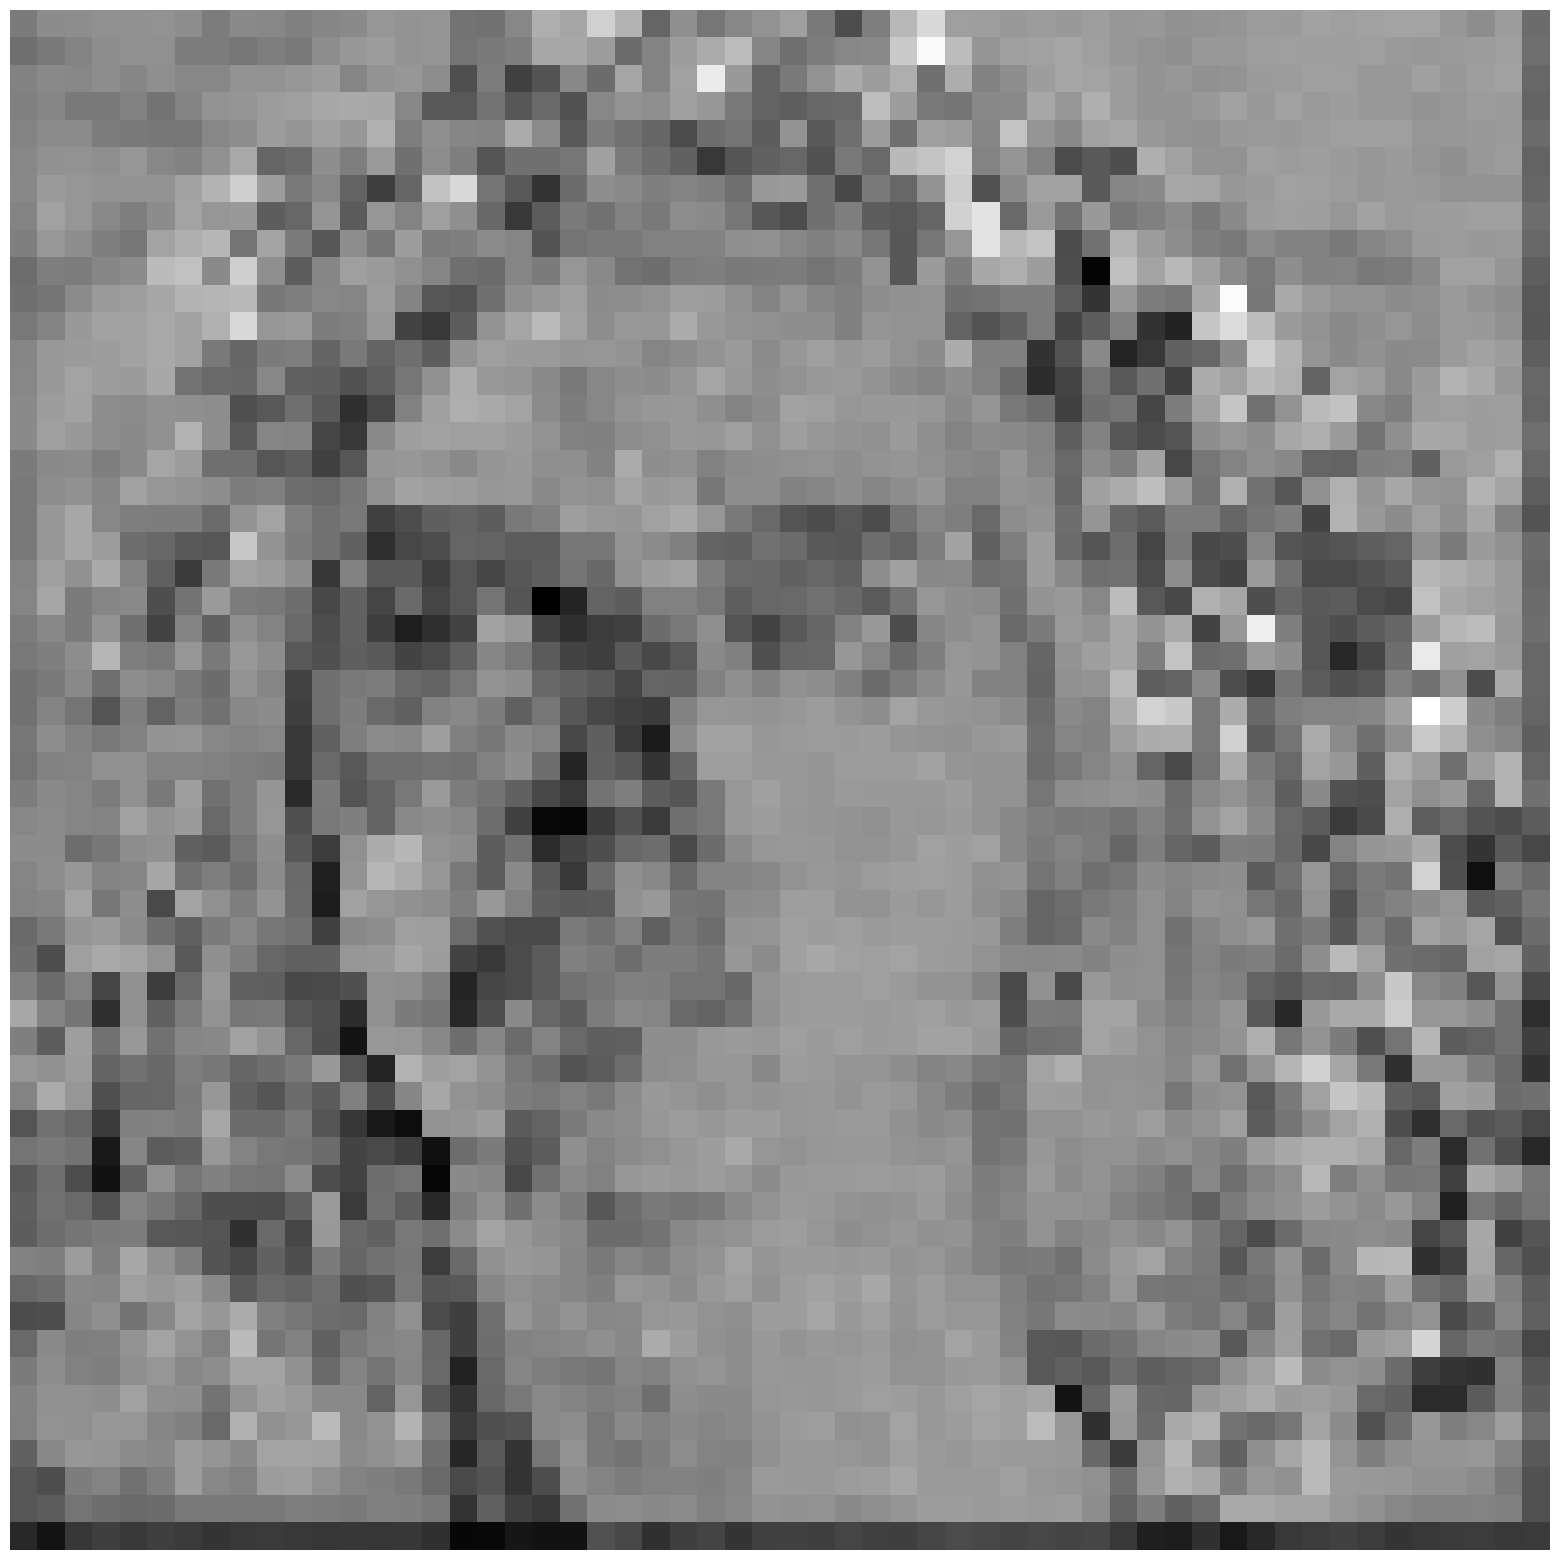

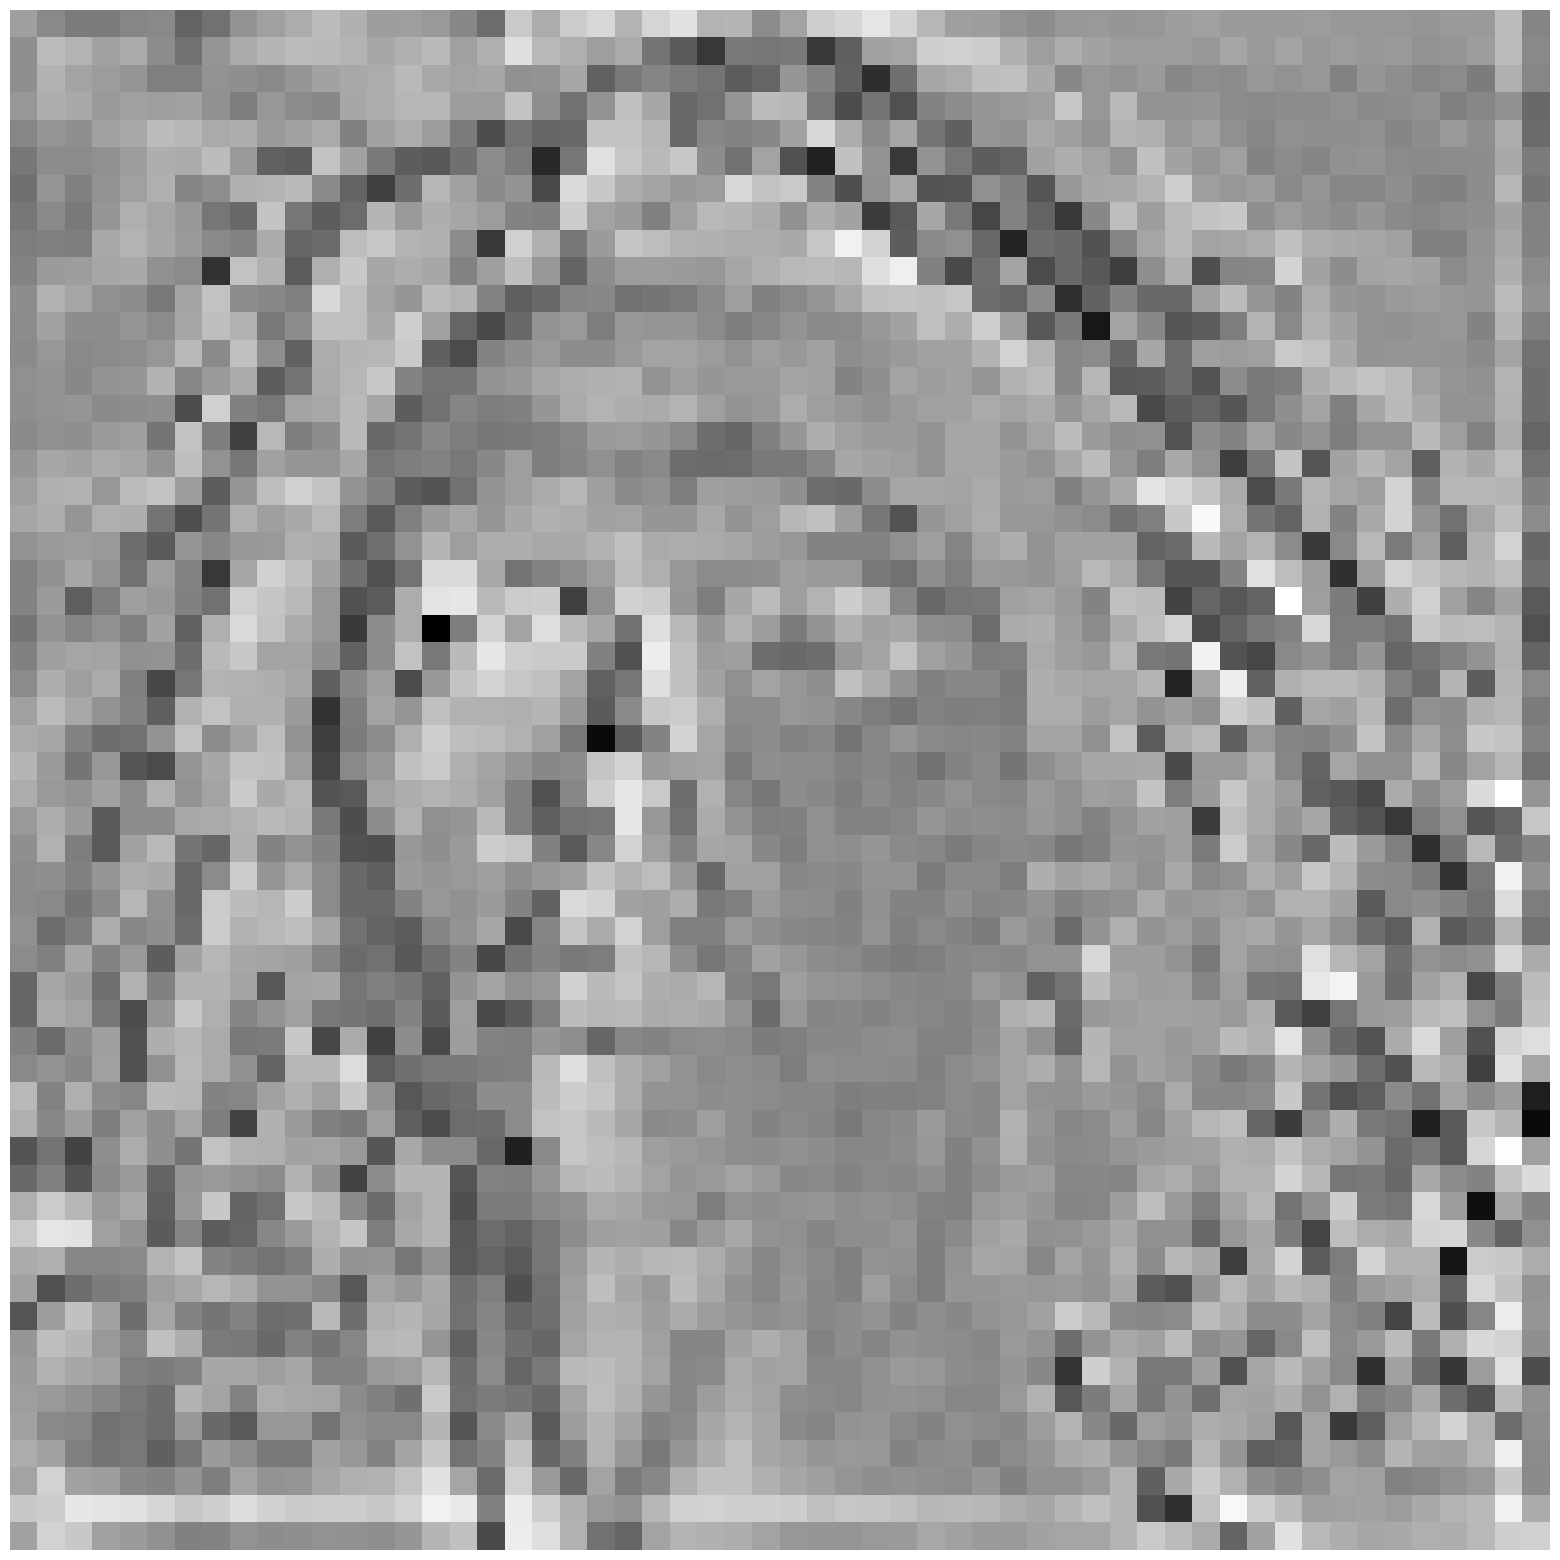

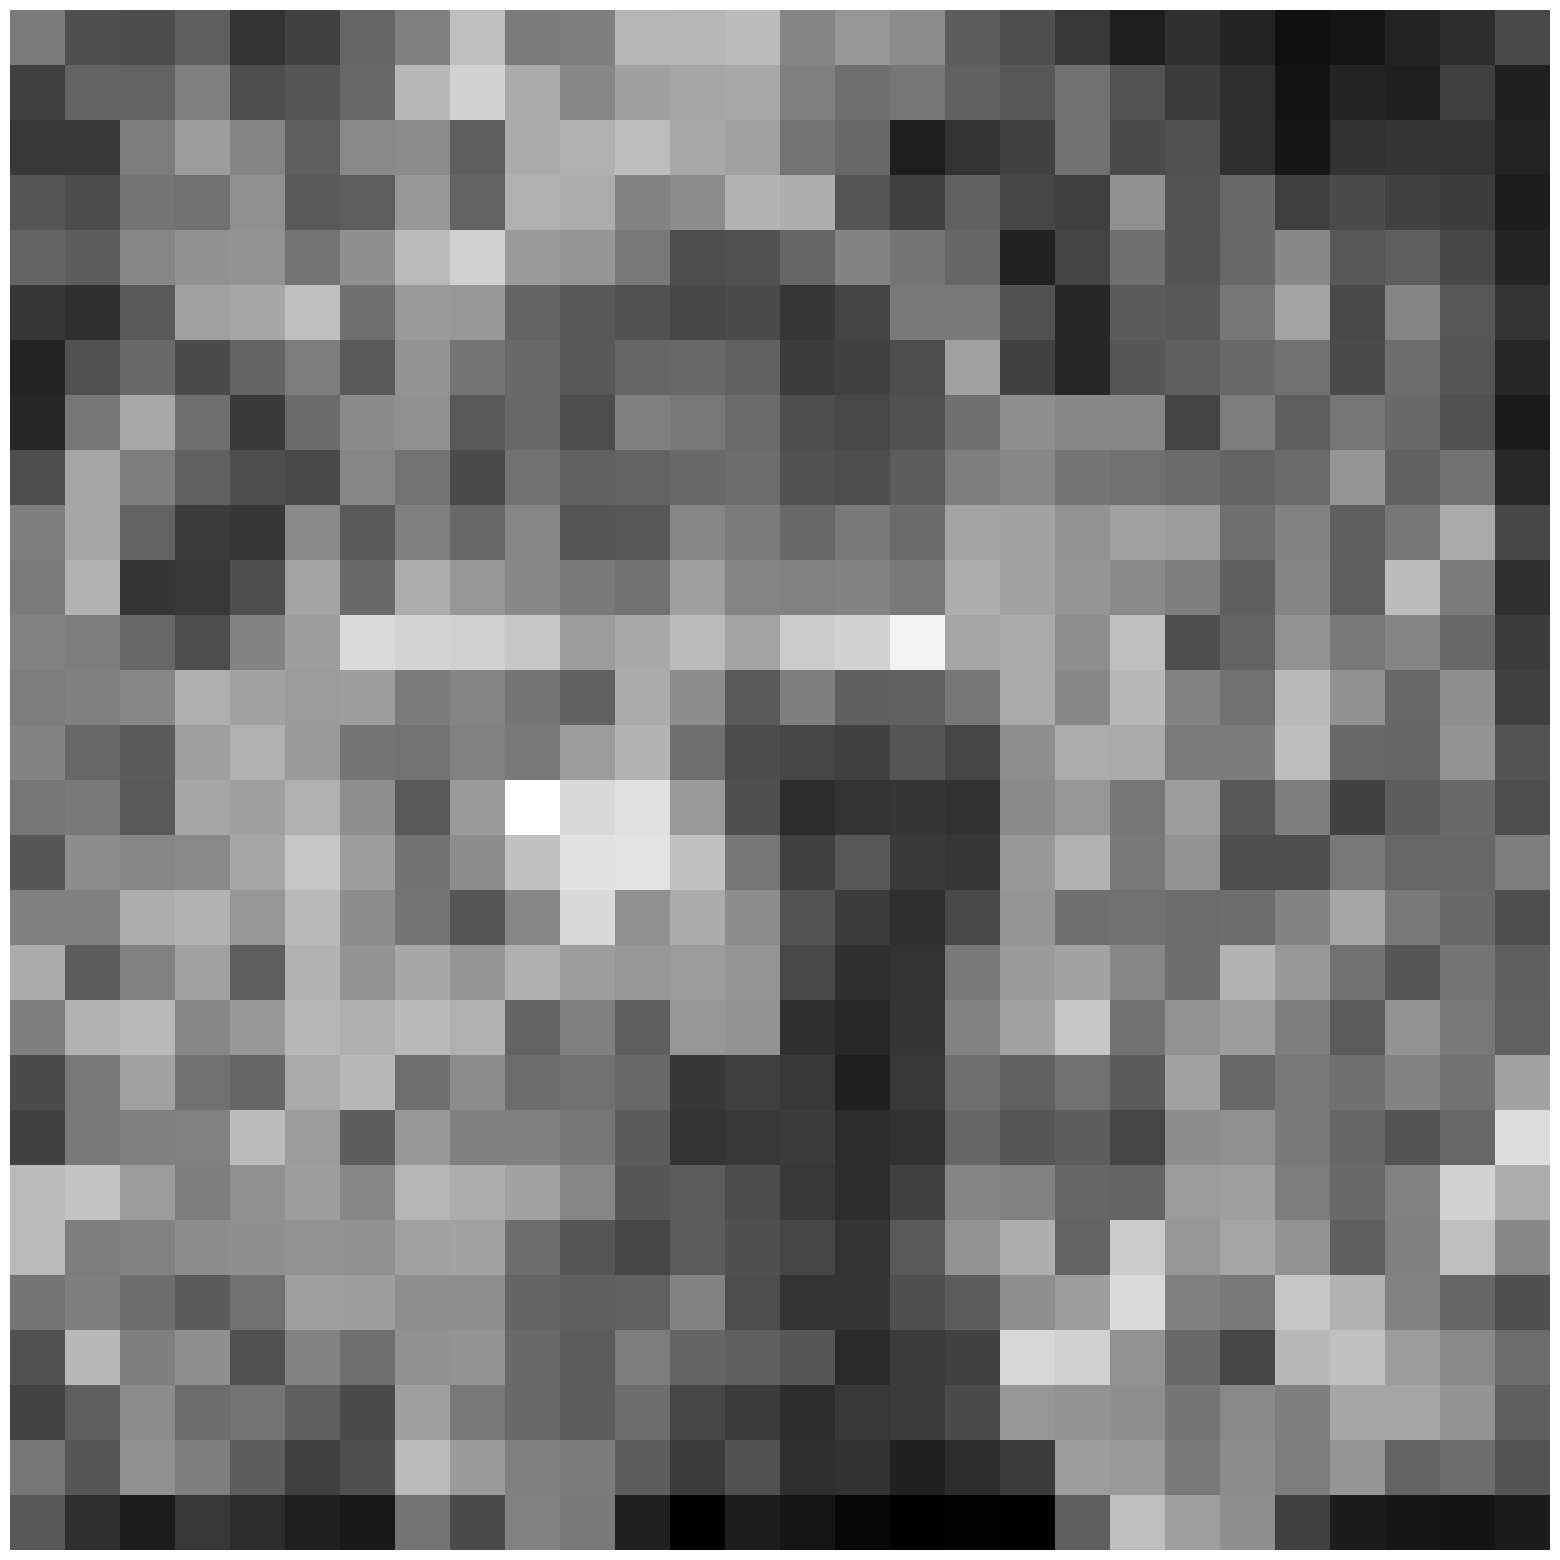

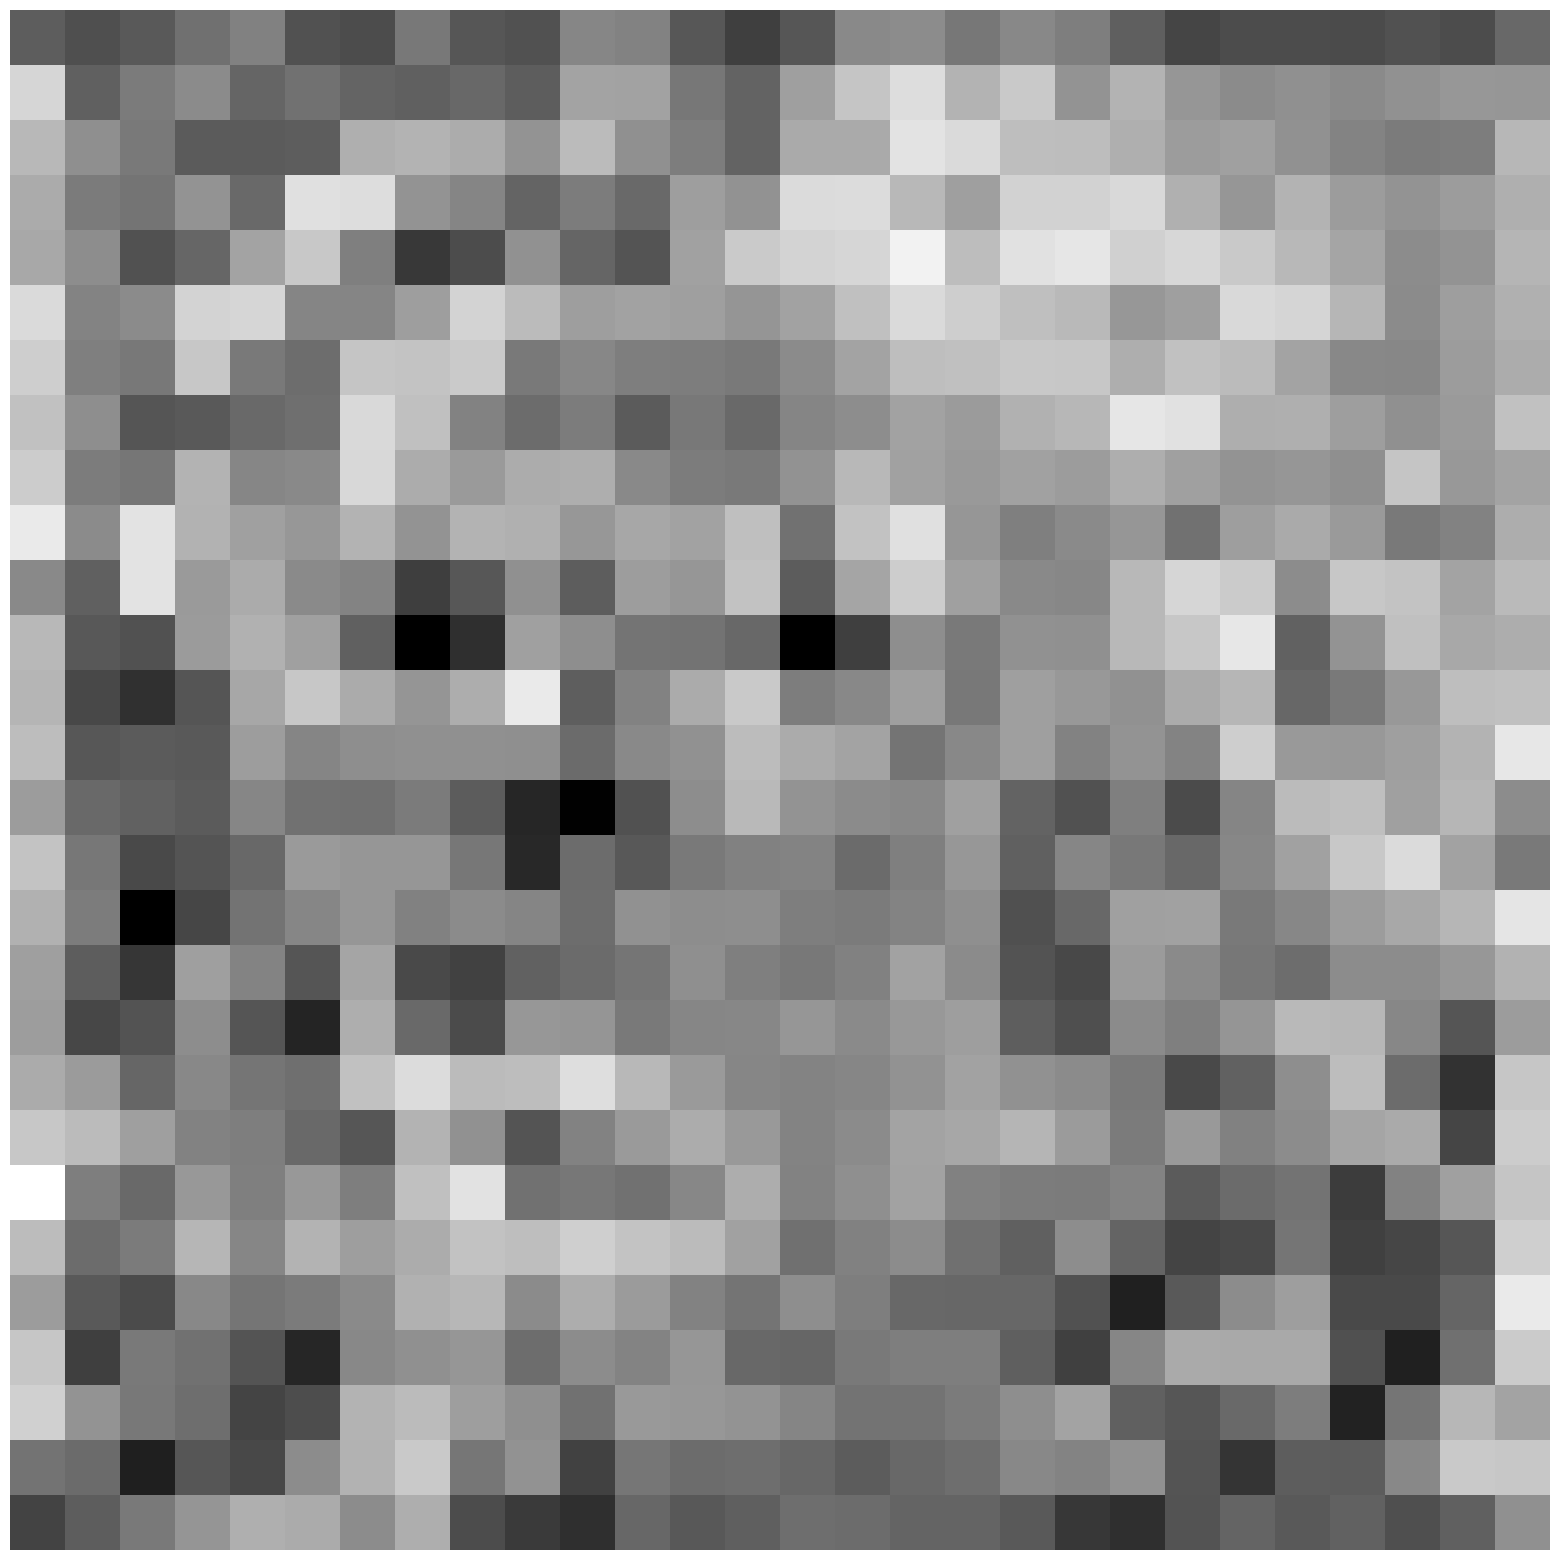

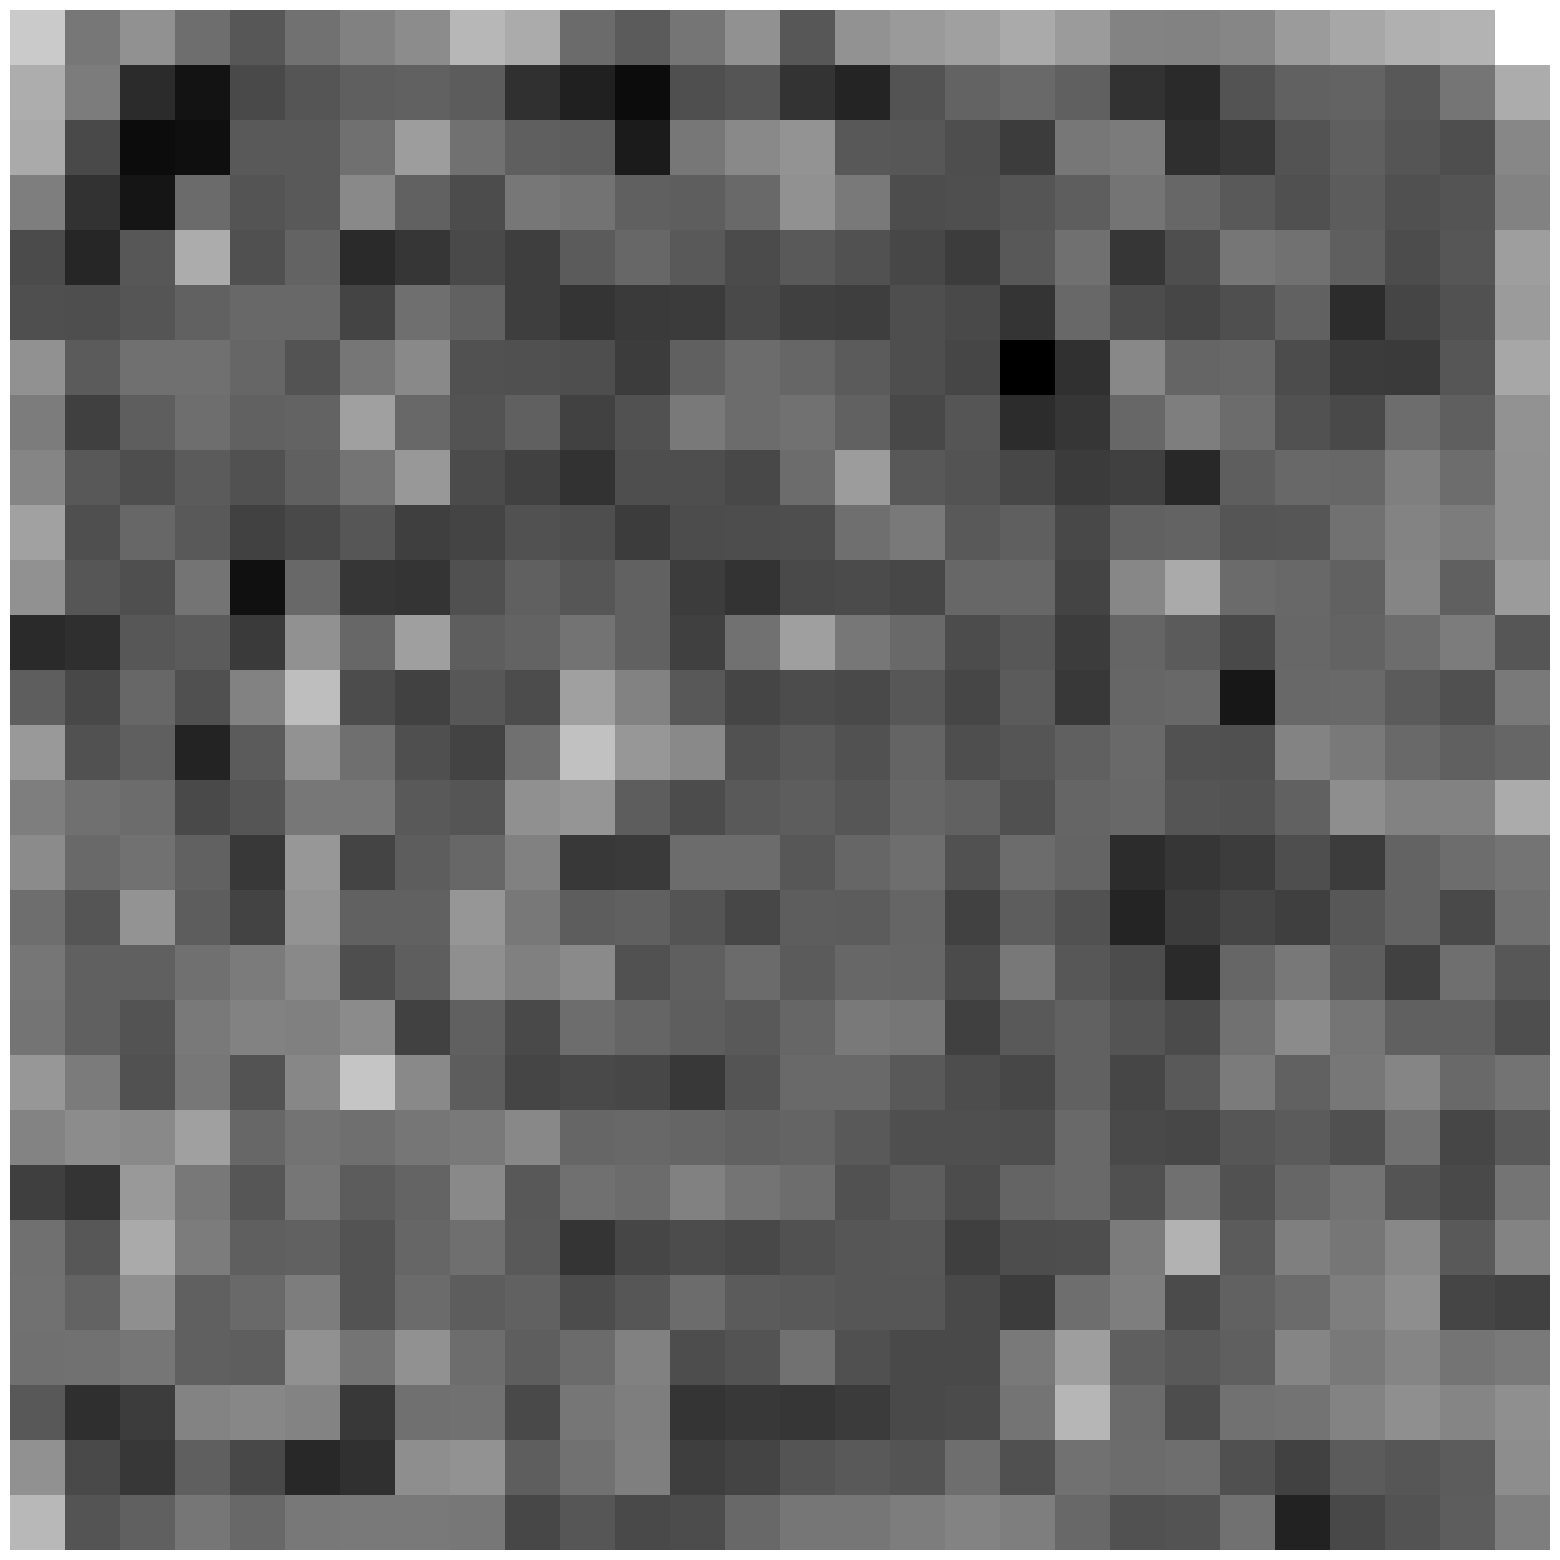

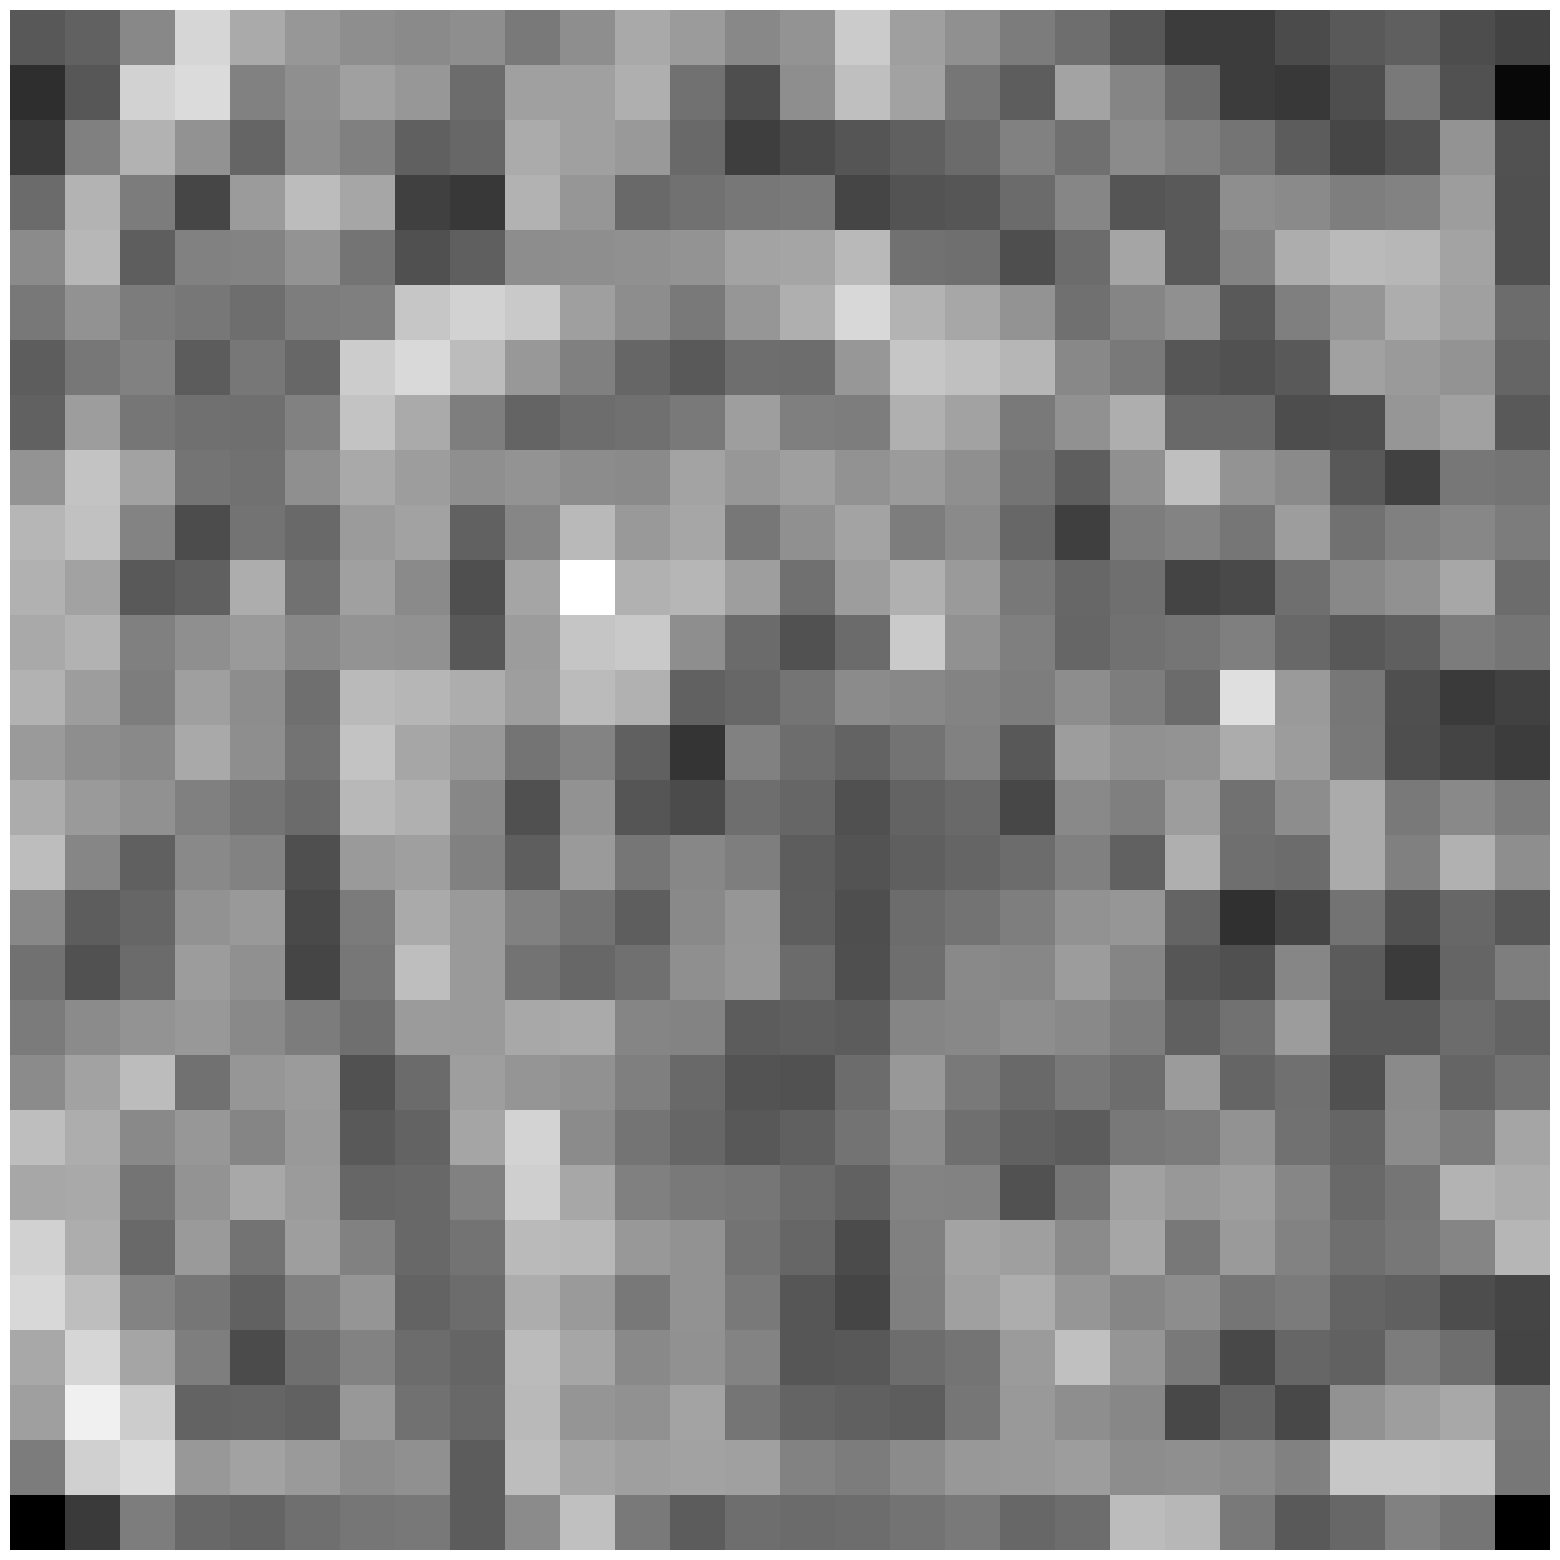

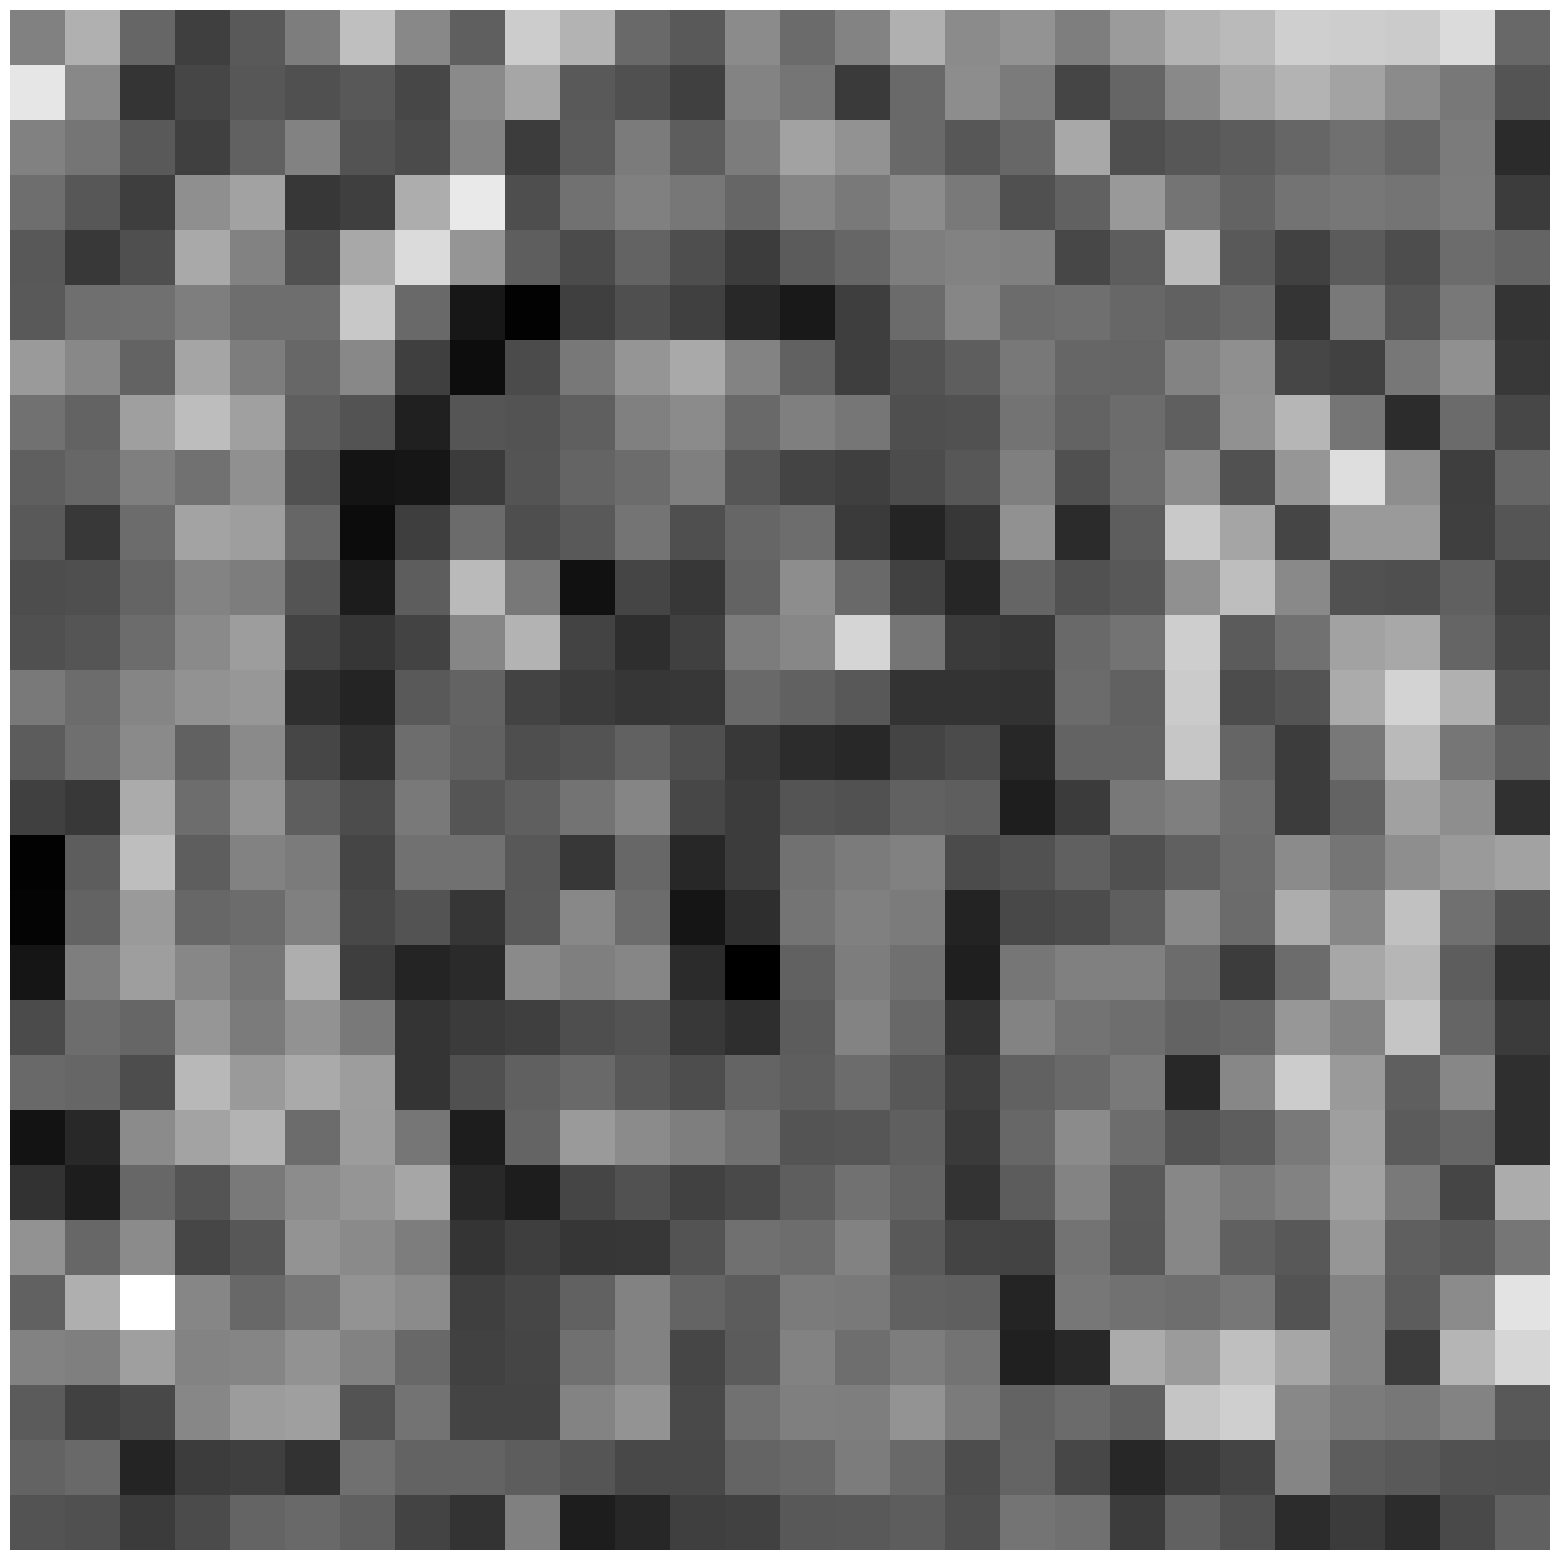

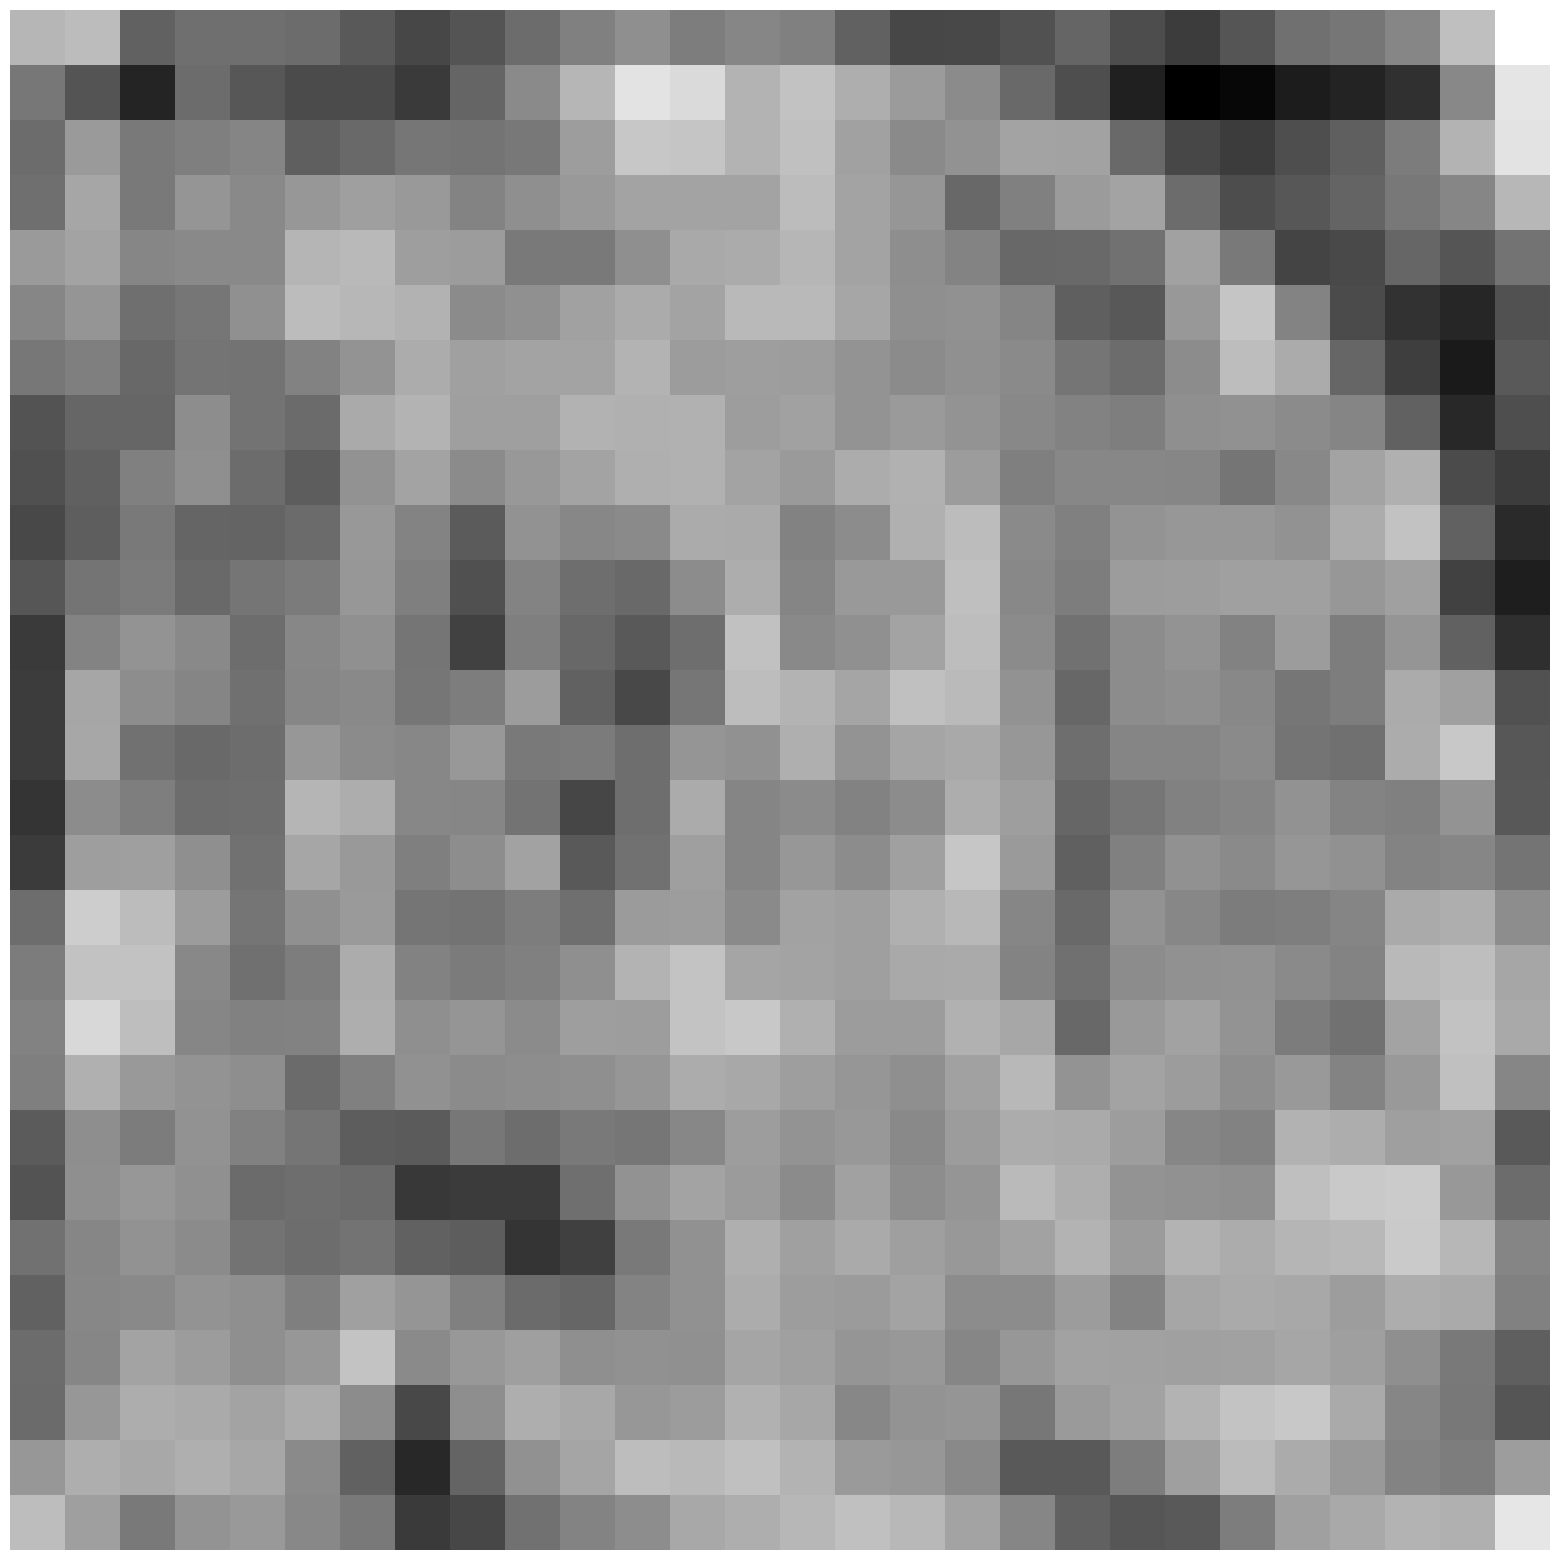

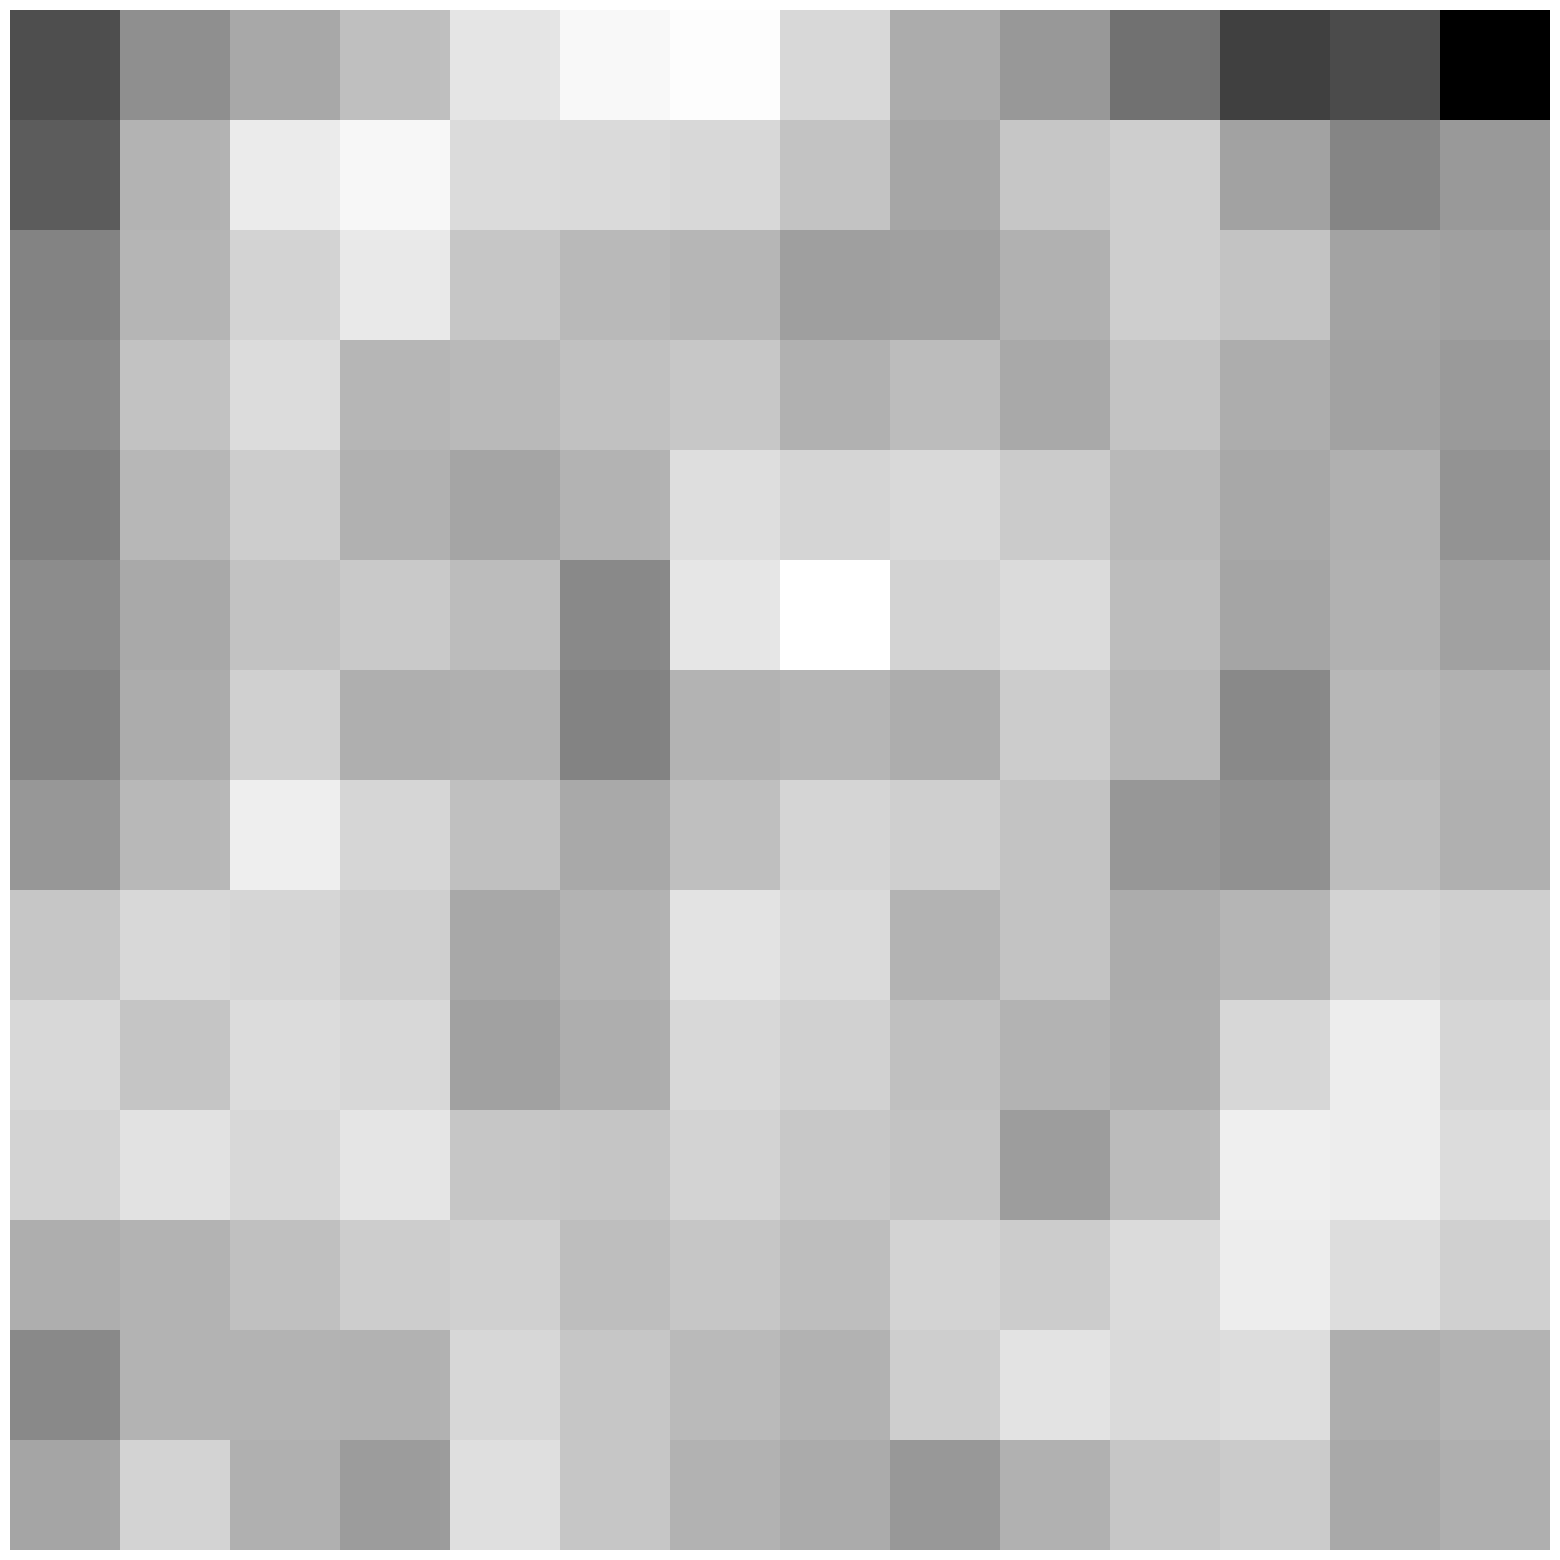

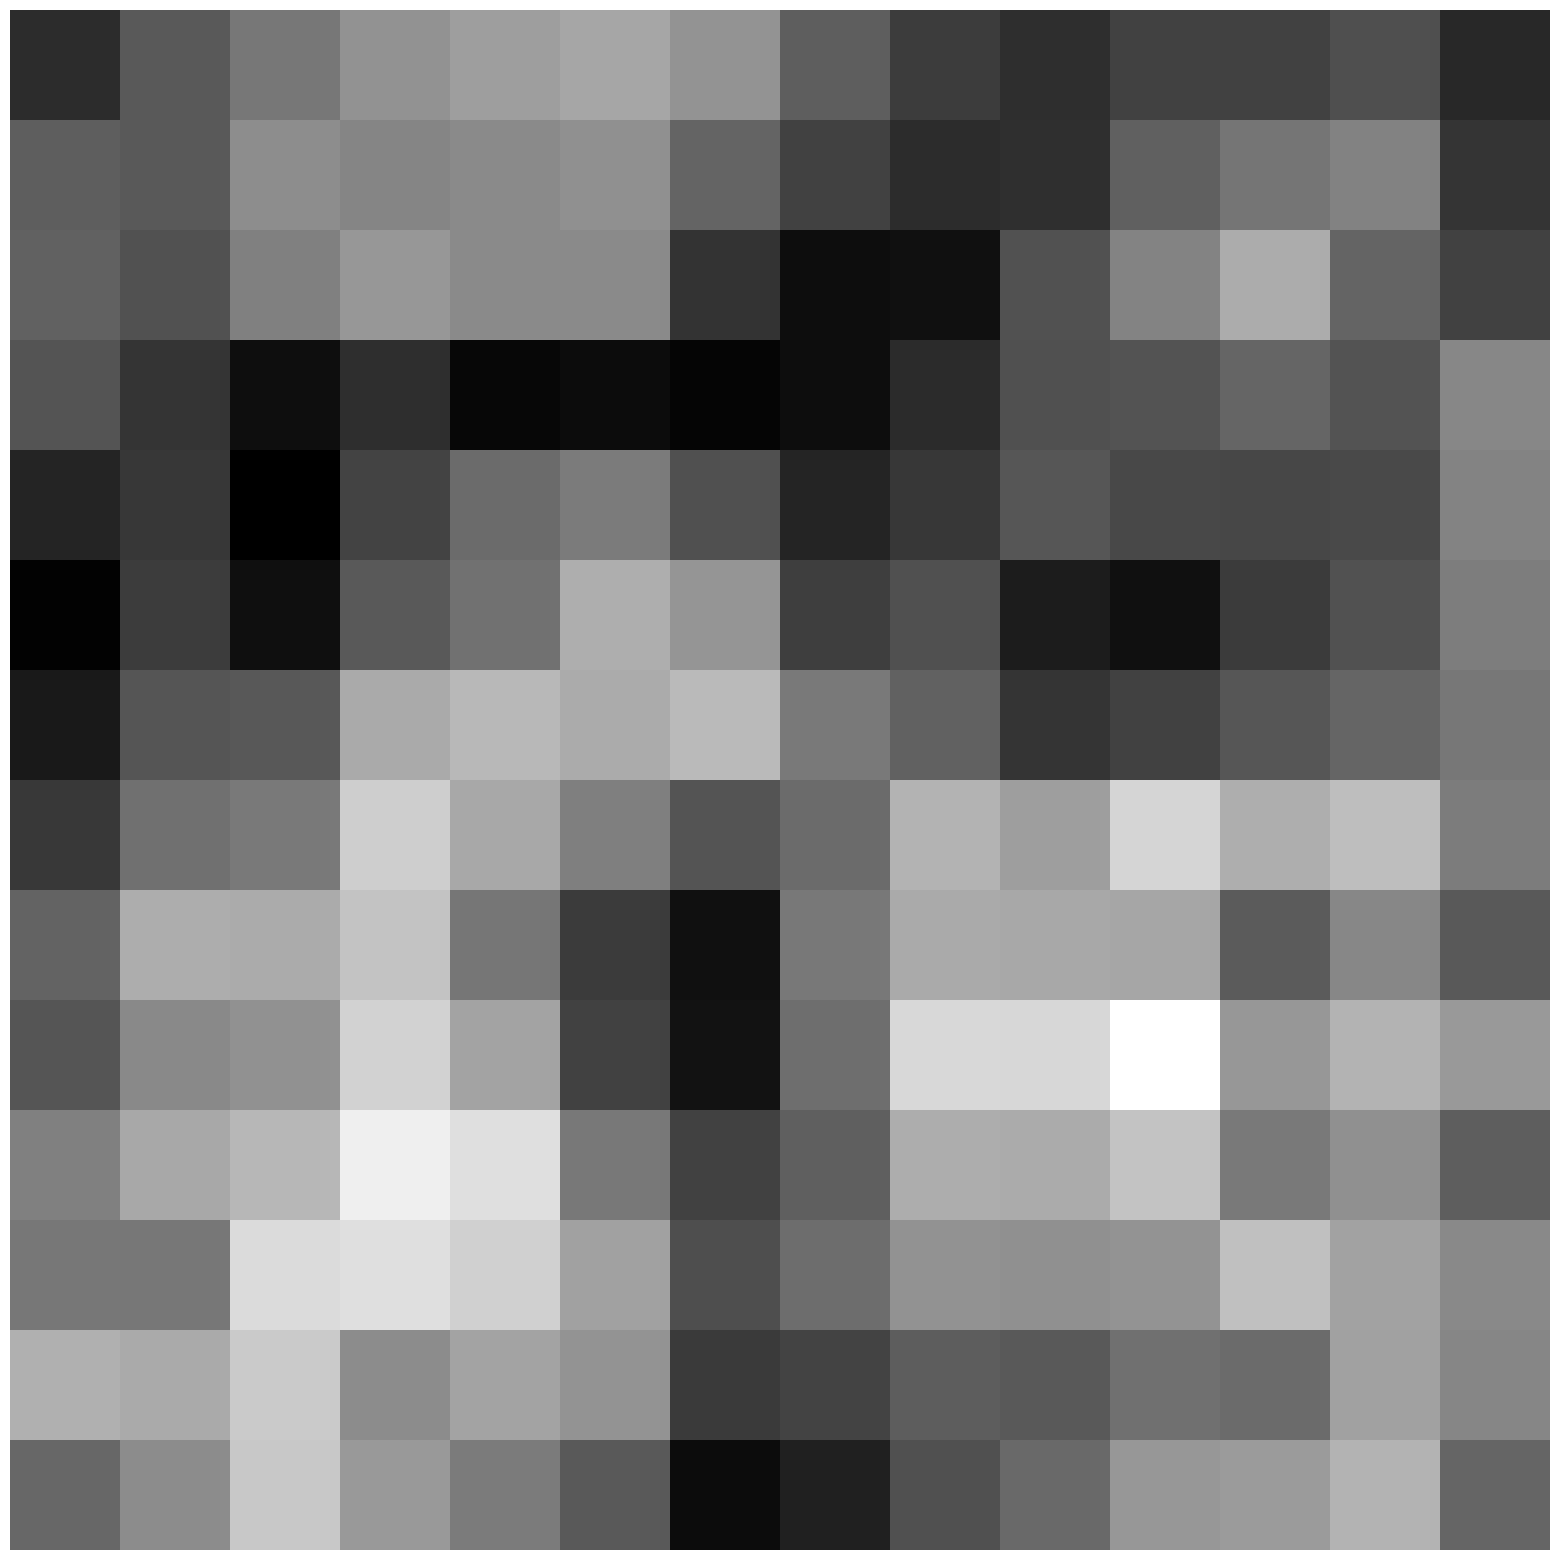

In [51]:
activations_model = Model(inputs = base_model.inputs, outputs = base_model_layer_outputs)
feature_maps = activations_model.predict(image_to_nparray_macro("./Celebrity_Faces_Test/Scarlett_Johansson_Test_2.jpg"), verbose = 1)

for index, layer in enumerate(feature_maps):
    print(feature_maps[index].shape)
    plt.figure(figsize = (20, 20))
    num_filters = feature_maps[index].shape[-1] 
    plt.imshow(feature_maps[index][0,:,:,num_filters - 1], cmap = "gray")
    plt.axis("off")
plt.show()
plt.close()

In [114]:
#Just in case we need to do a final training using a very low 
#learning rate about 1e-5
log_history = CSVLogger("my_mobilenet_history_ver_3.csv", append = True)
save_model = ModelCheckpoint("my_mobilenet_v3_model.keras", monitor= "val_accuracy", save_best_only= True)
save_weight = ModelCheckpoint("my_mobilenet_v3.weights.h5", monitor= "val_accuracy", save_weights_only= True, save_best_only= True)
base_model.trainable = True
transfer_model.load_weights("my_mobilenet_v3.weights.h5")
transfer_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate= 0.000001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy", keras.metrics.F1Score, keras.metrics.Precision, keras.metrics.Recall],
)

transfer_model.summary(show_trainable=True)


C:\Users\nhle1\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 172 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)       │ (None, 14, 14, 1024)          │      3,228,864 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ global_average_pooling2d_1            │ (None, 1024)                  │              0 │    -    │
│ (GlobalAveragePooling2D)              │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dense_2 (Dense)                       │ (None, 512)                   │        524,800 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ activation_7 (Activation)             │ (None, 512)                   │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dropout_1 (Dropout)                   │ (None, 512)                   │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dense_3 (Dense)                       │ (None, 17)                    │          8,721 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ activation_8 (Activation)             │ (None, 17)                    │              0 │    -    │
└───────────────────────────────────────┴───────────────────────────────┴────────────────┴─────────┘

 Total params: 3,762,385 (14.35 MB)

 Trainable params: 3,740,497 (14.27 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
new_transfer_history = transfer_model.fit(
        training_set,
        steps_per_epoch = 3200 // 32,
        epochs = 300,
        validation_data = validation_set,
        validation_steps = 600 // 16,
        callbacks = [ log_history, save_model, save_weight]
)

In [26]:
base_transfer_model = load_model("mobilenet_transfered_model.keras")
fine_tuned_model = load_model("my_mobilenet_v3_model.keras")

C:\Users\nhle1\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step
(636, 17) 636 (636,)


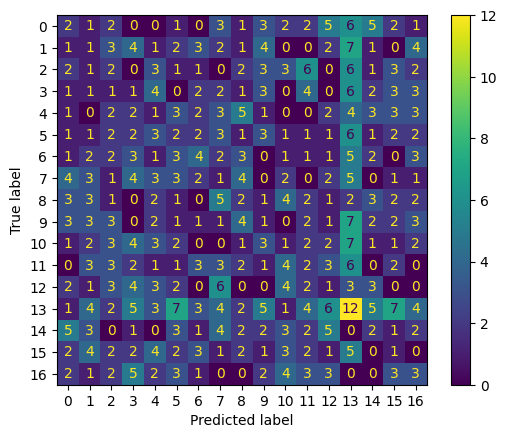

In [50]:
show_cm(model, testing_set)

40/40 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step
(636, 17) 636 (636,)


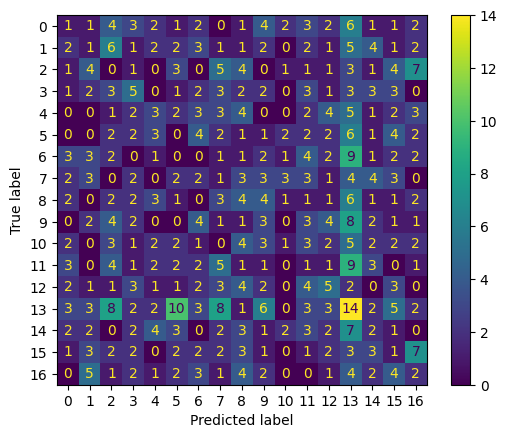

In [51]:
show_cm(base_transfer_model, testing_set )

40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 815ms/step
(636, 17) 636 (636,)


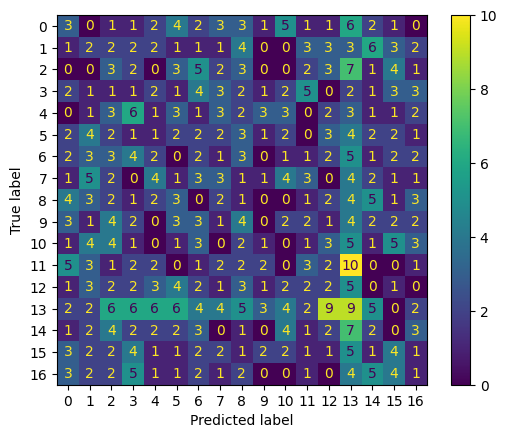

In [54]:
show_cm(fine_tuned_model, testing_set )

In [80]:
model_metrics = model.evaluate(testing_set, verbose = 1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.9405 - f1_score: 0.9275 - loss: 0.5022 - precision_1: 0.9640 - recall_1: 0.8909


In [78]:
base_transfer_model_metrics = transfer_model.evaluate(testing_set, verbose = 1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 693ms/step - accuracy: 0.8267 - f1_score: 0.8009 - loss: 0.8069 - precision: 0.9436 - recall: 0.5608


In [184]:
fine_tuned_transfer_model_metrics = transfer_model.evaluate(testing_set, verbose = 1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 749ms/step - accuracy: 0.8074 - f1_score: 0.7841 - loss: 0.7286 - precision_4: 0.9035 - recall_4: 0.6579


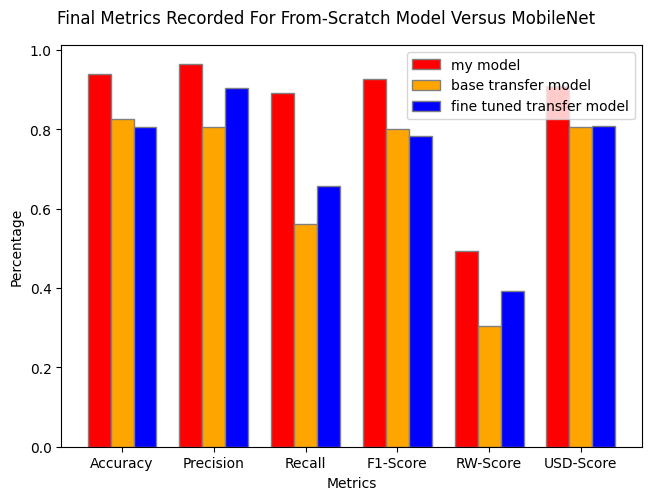

In [216]:
def plot_final_stat():
    barWidth= 0.25 
    fig = plt.subplots(layout = "constrained")
    
    my_model_stat = [0.9405, 0.9640, 0.8909, 0.9275, 0.4936708860759494,  0.91]
    base_transfer_model = [0.8267, 0.8069, 0.5608, 0.8009, 0.3037974683544304, 0.806  ]
    fined_tune_transfer_model = [0.8074, 0.9035, 0.6579, 0.7841, 0.3924050632911392, 0.81]

    plot_a = np.arange(len(my_model_stat))
    plot_b = [x + barWidth for x in plot_a]
    plot_c = [x + barWidth for x in plot_b]
    plot_d = [x + barWidth for x in plot_c]
    plt.suptitle("Final Metrics Recorded For From-Scratch Model Versus MobileNet", ha = "center", va = "center")
    plt.bar(plot_a, my_model_stat ,label = "my model", color = "red", edgecolor = "gray", width= barWidth)
    plt.bar(plot_b, base_transfer_model ,label = "base transfer model", color = "orange", edgecolor = "gray", width = barWidth)
    plt.bar(plot_c, fined_tune_transfer_model ,label = "fine tuned transfer model", color = "blue", edgecolor = "gray", width = barWidth)
    plt.xlabel("Metrics")
    plt.ylabel("Percentage")
    plt.legend()
    plt.xticks([r + barWidth for r in range(6)], ["Accuracy", "Precision", "Recall", "F1-Score", "RW-Score", "USD-Score"])

    plt.show()

plot_final_stat()

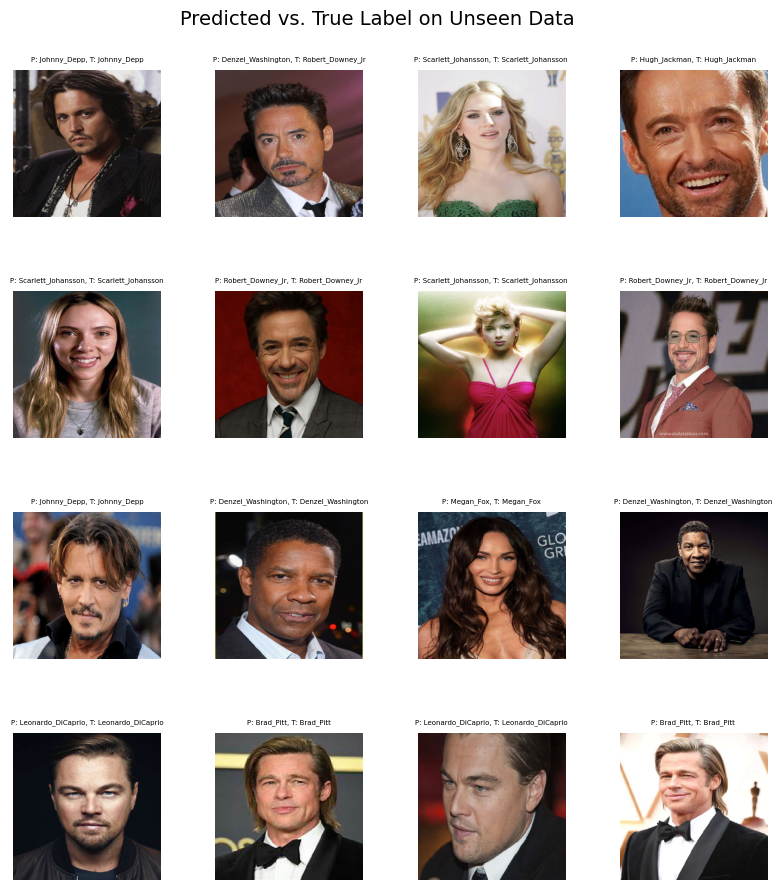

0.9375

In [192]:
predict_unseen_testing_set(model, testing_set)

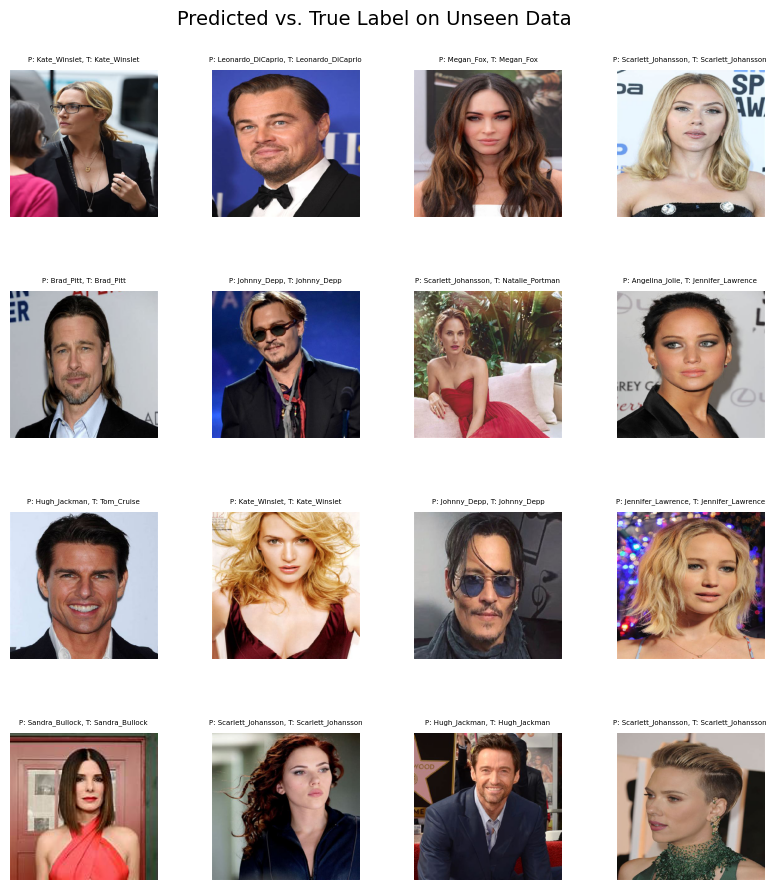

0.8125

In [170]:
predict_unseen_testing_set(base_transfer_model, testing_set)

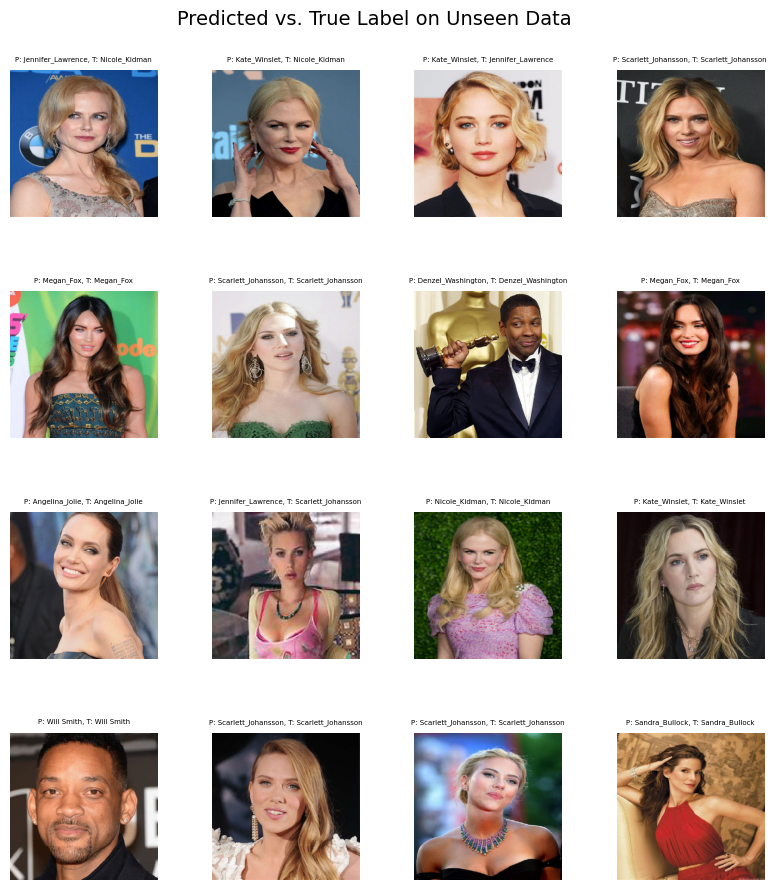

0.75

In [214]:
predict_unseen_testing_set(fine_tuned_model, testing_set)

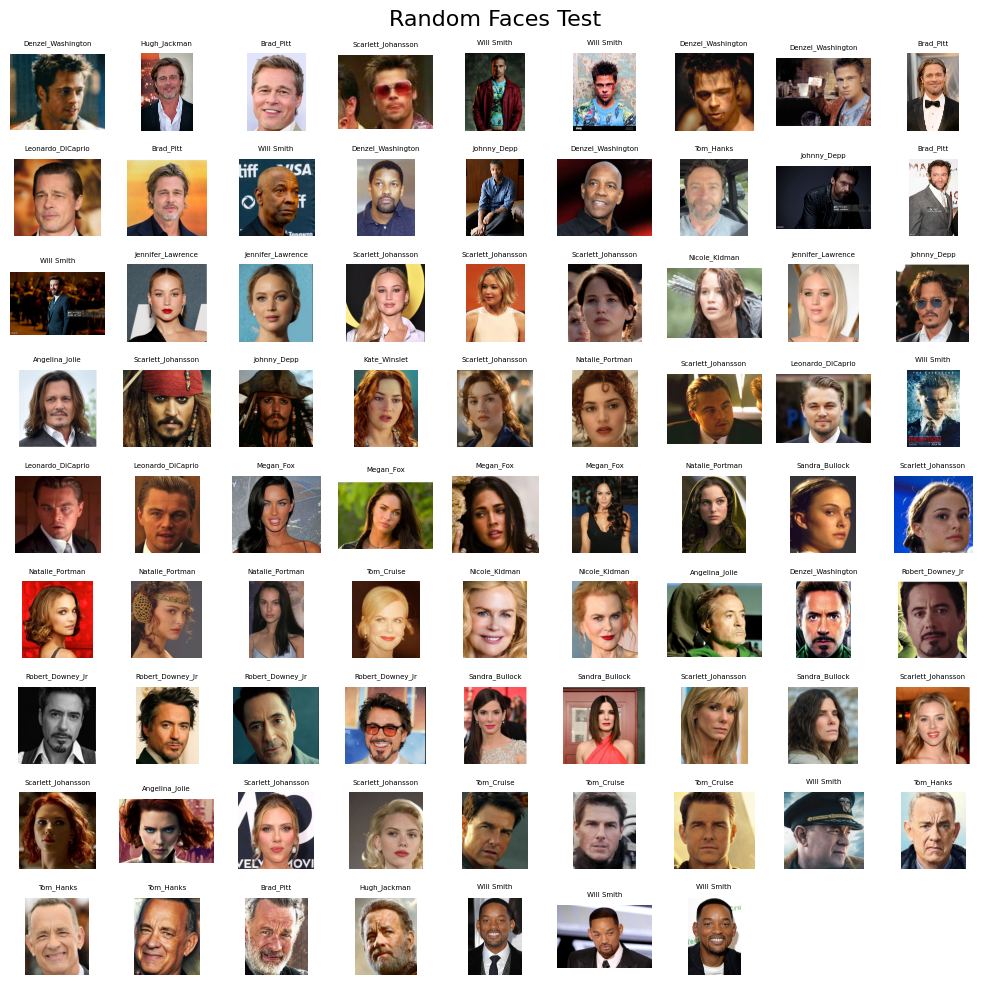

In [73]:
model_res = Random_Faces_Test(model)

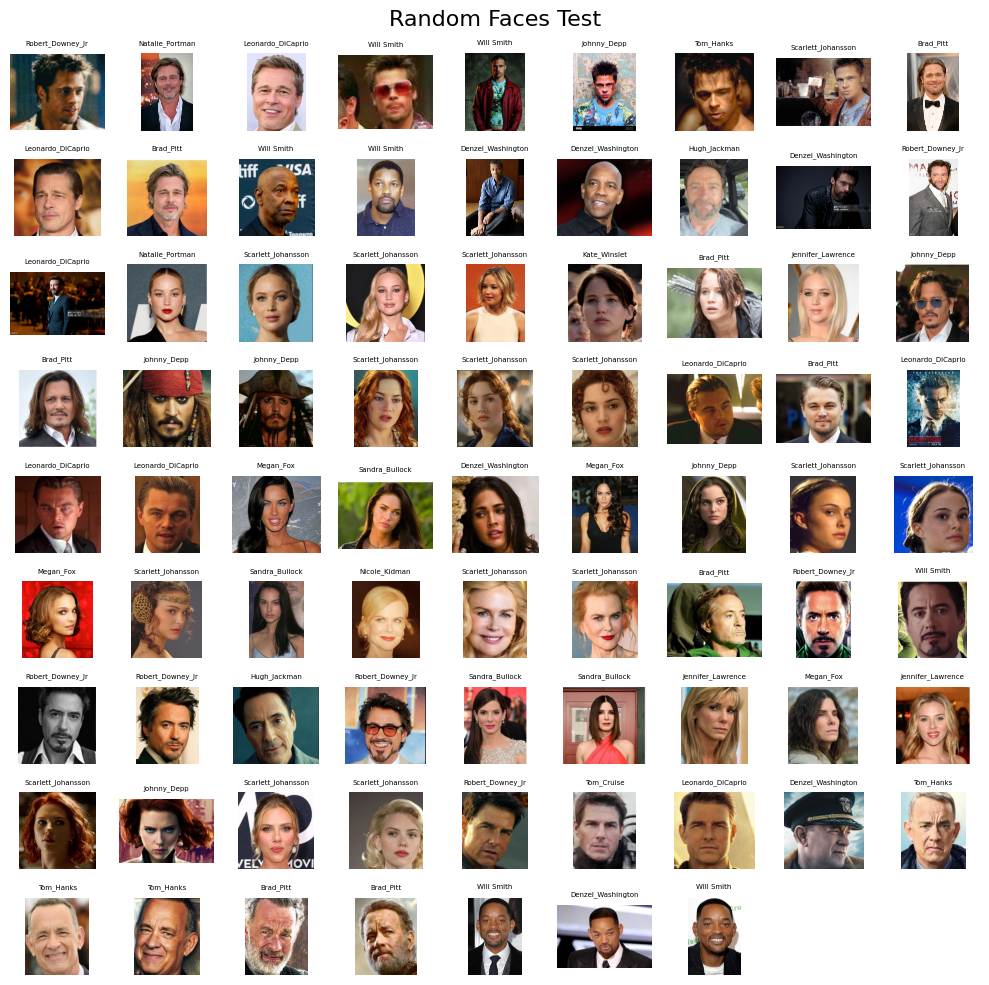

In [74]:
base_transfer_res = Random_Faces_Test(base_transfer_model)

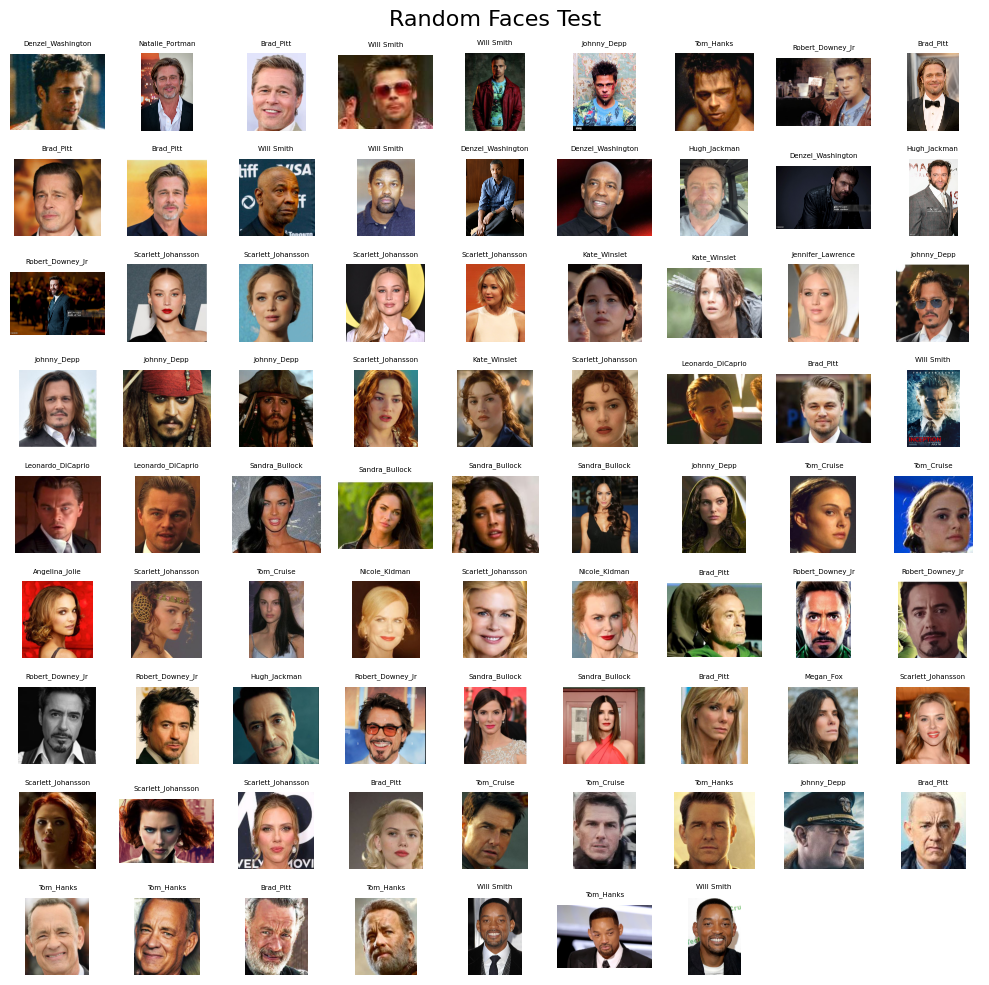

In [71]:
fined_tuned_transfer_res = Random_Faces_Test(fine_tuned_model)

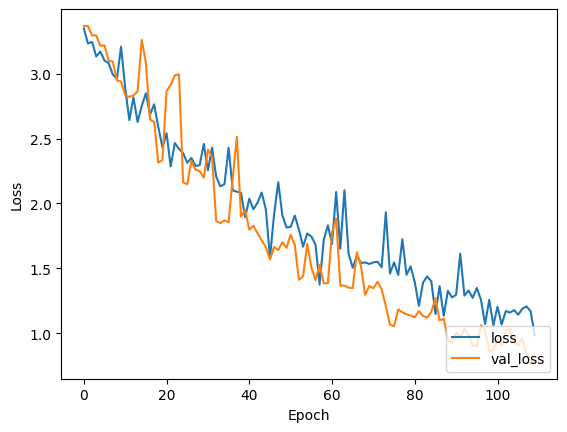

In [240]:
plot_history("my_model_history.csv")

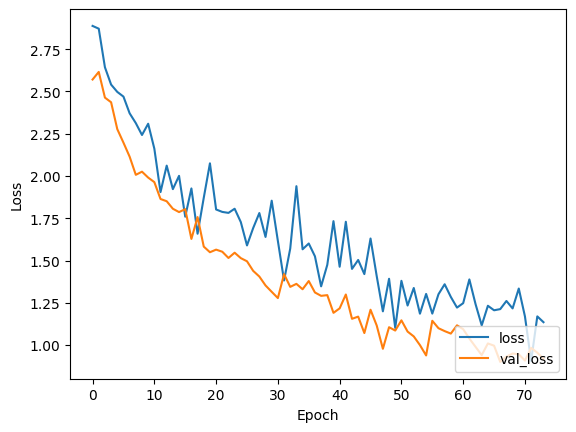

In [252]:
plot_history("transfer_mobilenet.log.csv")

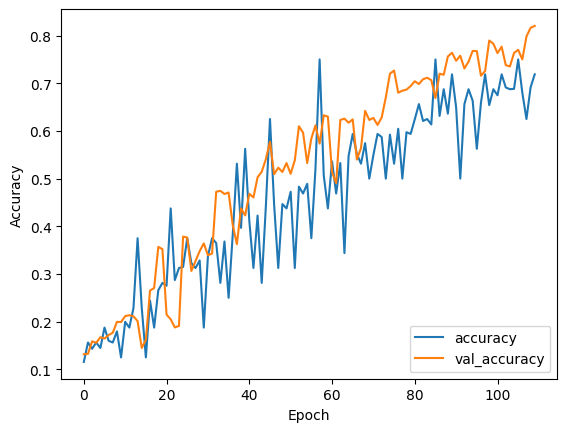

In [148]:
plot_history("my_model_history.csv")

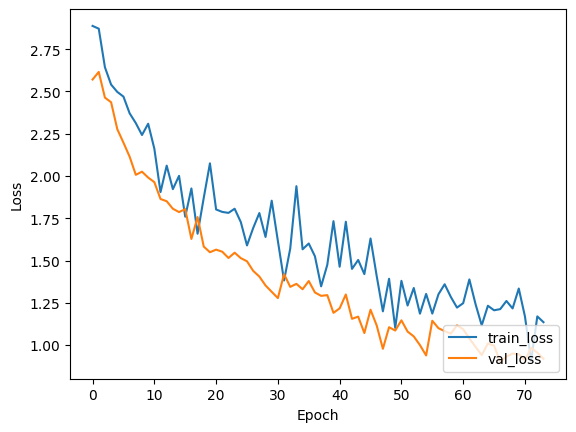

In [19]:
plot_history("transfer_mobilenet.log.csv")

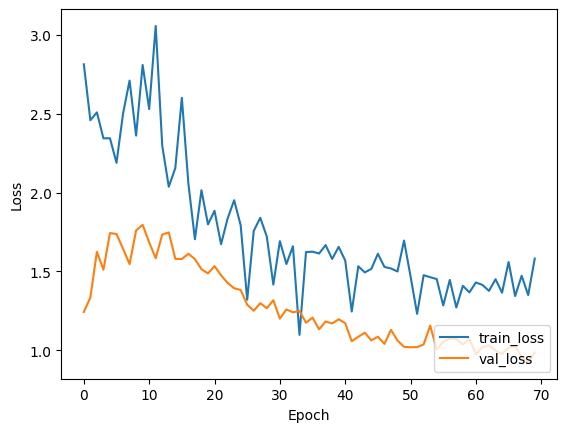

In [21]:
plot_history("my_mobilenet_history_ver_3.csv")